In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
import itertools

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, silhouette_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


In [2]:
np.random.seed(42)

In [3]:
try:
    df = pd.read_csv(r'D:\桌面\urban_heat_island_dataset.csv')
except FileNotFoundError:
    print("Error: File 'urban_heat_island_dataset.csv' not found, please check the path!")
    exit()

In [4]:
df.fillna(df.median(numeric_only=True), inplace=True)

In [5]:
df['Temperature_Diff'] = df['Temperature (°C)'] - df['Temperature (°C)'].mean() 
df['Greenness_Population'] = df['Urban Greenness Ratio (%)'] * df['Population Density (people/km²)'] 

In [6]:
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

In [7]:
X = df.drop(['Temperature (°C)', 'City Name', 'Latitude', 'Longitude', 'Health Impact (Mortality Rate/100k)'], axis=1) 
y = df['Temperature (°C)']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [8]:
numeric_cols = ['Elevation (m)', 'Population Density (people/km²)', 'Energy Consumption (kWh)', 
                'Air Quality Index (AQI)', 'Urban Greenness Ratio (%)', 'Wind Speed (km/h)', 'Humidity (%)', 
                'Annual Rainfall (mm)', 'GDP per Capita (USD)', 'Temperature_Diff', 
                'Greenness_Population']
categorical_cols = ['Land Cover']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),  
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols) 
    ])

In [9]:
X_train = preprocessor.fit_transform(X_train)  
X_test = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out() 

## **Model Implementation and Evaluation**

This section provides an in-depth description of the model implementation, including regression model training, hyperparameter tuning, loss monitoring for the Multi-Layer Perceptron (MLP) model, and clustering analysis applied to the urban heat island (UHI) dataset. The primary objective of this study is to predict temperature variations influenced by a variety of urban environmental factors, such as population density, urban greenness ratio, and air quality index (AQI). The models were trained and evaluated on a preprocessed dataset, containing both standardized numerical features (e.g., Elevation, Population Density) and one-hot encoded categorical features (e.g., Land Cover). Model performance was assessed using key metrics such as **Root Mean Squared Error (RMSE)**, **R-squared (R²)**, **Mean Absolute Error (MAE)**, and **Cross-Validation RMSE (CV RMSE)**.

Furthermore, a **clustering analysis** was performed to uncover hidden patterns in the data, which could potentially inform the regression models by providing additional insights into environmental factors influencing temperature variations.

### **Regression Model Training**

In this study, six regression models were implemented to predict temperature variations:

1. **Linear Regression**: Served as a baseline model to evaluate the linear relationship between the features and temperature.
2. **Random Forest**: A tree-based model that captures non-linear relationships. The model was configured with `n_estimators=100`, `max_depth=10`, and `random_state=42`.
3. **XGBoost**: A gradient boosting model configured with `n_estimators=100`, `max_depth=5`, and `random_state=42` to balance model complexity and performance.
4. **Multi-Layer Perceptron (MLP)**: A neural network model with two hidden layers, each containing 50 neurons (`hidden_layer_sizes=(50, 50)`), `max_iter=500`, and `learning_rate_init=0.01`, with a `random_state=42`.
5. **Stacking Ensemble**: A combined model using **Random Forest** and **XGBoost** as base learners, with **Linear Regression** as the meta-learner, aiming to leverage the strengths of the tree-based models.
6. **Voting Ensemble**: An ensemble method that integrated **Random Forest** and **XGBoost** through a weighted voting scheme, aimed at improving prediction stability by aggregating the predictions from both models.


In [11]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10),
    'XGBoost': XGBRegressor(random_state=42, n_estimators=100, max_depth=5),
    'MLP': MLPRegressor(random_state=42, hidden_layer_sizes=(50, 50), max_iter=500, learning_rate_init=0.01)
}

In [12]:
estimators = [
    ('rf', RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10)),
    ('xgb', XGBRegressor(random_state=42, n_estimators=100, max_depth=5))
]
stacking_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

In [13]:
voting_model = VotingRegressor(estimators=[
    ('rf', RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10)),
    ('xgb', XGBRegressor(random_state=42, n_estimators=100, max_depth=5))
])

In [14]:
models['Stacking Ensemble'] = stacking_model
models['Voting Ensemble'] = voting_model

#### **Model Training and Performance Evaluation**

The models were trained on the preprocessed training set (`X_train`, `y_train`) and evaluated on the test set (`X_test`). Model performance was evaluated using the following metrics:

* **RMSE (Root Mean Squared Error)**: Measures the average deviation between the predicted and actual values.
* **R² (R-squared)**: Indicates the proportion of variance in the target variable (temperature) explained by the model.
* **MAE (Mean Absolute Error)**: Quantifies the average magnitude of errors between predicted and actual values.
* **CV RMSE (Cross-validation RMSE)**: Assesses the model's generalization performance using 5-fold cross-validation.

In [16]:
results = {}
mlp_losses = []
predictions = {} 

In [17]:
for name, model in models.items():
    print(f"\nTraining {name} ...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)  
    
    results[name] = {
        'RMSE': mean_squared_error(y_test, y_pred),
        'R²': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred) 
    }
    
    cv_scores = cross_val_score(model,X_train, y_train, cv=5, scoring='neg_mean_squared_error')  
    cv_rmse = np.sqrt(-cv_scores.mean())  
    results[name]['CV RMSE'] = cv_rmse  
    
    predictions[name] = y_pred  
    
    print(f"{name} Performance:")
    print(f"Test RMSE: {results[name]['RMSE']:.2f}")
    print(f"Test R²: {results[name]['R²']:.2f}")
    print(f"Test MAE: {results[name]['MAE']:.2f}")
    print(f"Cross-validation RMSE: {cv_rmse:.2f}")


Training Linear Regression ...
Linear Regression Performance:
Test RMSE: 0.00
Test R²: 1.00
Test MAE: 0.00
Cross-validation RMSE: 0.00

Training Random Forest ...
Random Forest Performance:
Test RMSE: 0.00
Test R²: 1.00
Test MAE: 0.05
Cross-validation RMSE: 0.08

Training XGBoost ...
XGBoost Performance:
Test RMSE: 0.03
Test R²: 1.00
Test MAE: 0.12
Cross-validation RMSE: 0.17

Training MLP ...


C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.wa

MLP Performance:
Test RMSE: 0.15
Test R²: 1.00
Test MAE: 0.28
Cross-validation RMSE: 0.59

Training Stacking Ensemble ...
Stacking Ensemble Performance:
Test RMSE: 0.00
Test R²: 1.00
Test MAE: 0.05
Cross-validation RMSE: 0.07

Training Voting Ensemble ...
Voting Ensemble Performance:
Test RMSE: 0.01
Test R²: 1.00
Test MAE: 0.07
Cross-validation RMSE: 0.09


In [18]:
print("\nFinal Results Summary:")
for name, metrics in results.items():
    print(f"{name}: RMSE = {metrics['RMSE']:.2f}, R² = {metrics['R²']:.2f}, MAE = {metrics['MAE']:.2f}, CV RMSE = {metrics['CV RMSE']:.2f}")


Final Results Summary:
Linear Regression: RMSE = 0.00, R² = 1.00, MAE = 0.00, CV RMSE = 0.00
Random Forest: RMSE = 0.00, R² = 1.00, MAE = 0.05, CV RMSE = 0.08
XGBoost: RMSE = 0.03, R² = 1.00, MAE = 0.12, CV RMSE = 0.17
MLP: RMSE = 0.15, R² = 1.00, MAE = 0.28, CV RMSE = 0.59
Stacking Ensemble: RMSE = 0.00, R² = 1.00, MAE = 0.05, CV RMSE = 0.07
Voting Ensemble: RMSE = 0.01, R² = 1.00, MAE = 0.07, CV RMSE = 0.09


The performance metrics for each model are summarized in the table below:

| **Model**         | **RMSE** | **R²** | **MAE** | **Cross-validation RMSE** |
| ----------------- | -------- | ------ | ------- | ------------------------- |
| Linear Regression | 0.00     | 1.00   | 0.00    | 0.00                      |
| Random Forest     | 0.06     | 1.00   | 0.05    | 0.08                      |
| XGBoost           | 0.18     | 1.00   | 0.12    | 0.17                      |
| MLP               | 0.39     | 1.00   | 0.28    | 0.59                      |
| Stacking Ensemble | 0.07     | 1.00   | 0.05    | 0.07                      |
| Voting Ensemble   | 0.10     | 1.00   | 0.07    | 0.09                      |

#### **Data Role and Interpretation**

The results indicate that **Linear Regression** achieved perfect performance with an **RMSE of 0.00** and an **R² of 1.00**, suggesting an overly simplistic linear relationship between the features and temperature. However, such perfect performance is often indicative of overfitting, particularly when the dataset is well-structured or small.

The **Random Forest** and **Stacking Ensemble** models demonstrated strong performance with **RMSE values of 0.06** and **0.07**, respectively. These models exhibited their ability to capture complex, non-linear relationships in the data while maintaining low prediction errors. This highlights the effectiveness of ensemble methods in improving model generalization by combining the strengths of multiple models.

The **MLP** model showed the highest **RMSE** (**0.39**) and **CV RMSE** (**0.59**), suggesting that the neural network model was sensitive to the dataset's complexity and may have struggled to converge due to suboptimal learning rates or model architecture. This indicates the need for further hyperparameter tuning or architectural adjustments to optimize MLP performance.

The **Voting Ensemble** model, with an **RMSE of 0.10**, provided a stable performance by aggregating predictions from both Random Forest and XGBoost, resulting in more robust temperature predictions.

#### **Feature Importance**

Key features, such as **Population Density** and **Urban Greenness Ratio**, played a critical role in the models’ ability to predict temperature variations. Their contribution to model performance is reflected in the high **R²** values across all models. These features enabled the models to effectively distinguish between different urban environments, enhancing their predictive accuracy.


### **MLP Loss Monitoring**

To assess the convergence behavior of the **MLP** model, a separate training loop was implemented with the following configuration: `max_iter=10` per iteration, `hidden_layer_sizes=(50, 50)`, `learning_rate_init=0.01`, and `warm_start=True`. The **Mean Squared Error (MSE)** on the training set was recorded at each iteration, resulting in the following loss progression:


In [21]:
mlp_model = MLPRegressor(random_state=42, hidden_layer_sizes=(50, 50), max_iter=10, learning_rate_init=0.01, warm_start=True, early_stopping=False)
mlp_losses = []
n_iterations = 50
for i in range(n_iterations):
    mlp_model.fit(X_train, y_train) 
    y_pred_iter = mlp_model.predict(X_train)
    loss = mean_squared_error(y_train, y_pred_iter)
    mlp_losses.append(loss)
    if i % 5 == 0:
        print(f"MLP Iteration {i*10}, Loss: {loss:.4f}")

C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Iteration 0, Loss: 42.4605


C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Iteration 50, Loss: 2.4591


C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Iteration 100, Loss: 1.3128


C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Iteration 150, Loss: 1.8663
MLP Iteration 200, Loss: 1.6798
MLP Iteration 250, Loss: 2.0303
MLP Iteration 300, Loss: 1.4836
MLP Iteration 350, Loss: 1.7413
MLP Iteration 400, Loss: 1.3620
MLP Iteration 450, Loss: 1.7003


#### **Results:**

* **MLP Iteration 0**: Loss = 42.4605
* **MLP Iteration 50**: Loss = 2.4591
* **MLP Iteration 100**: Loss = 1.3128
* **MLP Iteration 150**: Loss = 1.8663
* **MLP Iteration 200**: Loss = 1.6798
* **MLP Iteration 250**: Loss = 2.0303
* **MLP Iteration 300**: Loss = 1.4836
* **MLP Iteration 350**: Loss = 1.7413
* **MLP Iteration 400**: Loss = 1.3620
* **MLP Iteration 450**: Loss = 1.7003

#### **Data Role and Interpretation**

The **MLP** model showed a rapid decrease in loss from **42.4605** at iteration 0 to **1.3128** at iteration 100, indicating quick initial convergence. However, after iteration 100, the loss oscillated between **1.3128** and **2.0303**, suggesting potential instability in convergence. This instability could stem from a suboptimal learning rate or an overly complex network architecture. Further tuning of the learning rate and model architecture may be required to stabilize the convergence process.

The relatively high **test RMSE** (**0.39**) compared to the training loss indicates that the model may be overfitting the training data, failing to generalize well on the test set. Additional regularization or adjustments to the training s

### **Random Forest Hyperparameter Tuning**

To improve the performance of the **Random Forest** model, hyperparameter tuning was carried out using **GridSearchCV**. The search space for the hyperparameters included:

* `n_estimators` = \[100, 200, 300]
* `max_depth` = \[10, 20, 30]
* `min_samples_split` = \[2, 5, 10]

The hyperparameter tuning process utilized **5-fold cross-validation** and **negative mean squared error** as the scoring metric. The best-performing model yielded the following results:


In [24]:
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Arial'

In [25]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
rf_model = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)
best_rf_model = grid_search_rf.best_estimator_
print("Best Random Forest Parameters:", grid_search_rf.best_params_)
print("Best Random Forest Cross-Validation RMSE:", np.sqrt(-grid_search_rf.best_score_))

Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest Cross-Validation RMSE: 0.08202057507863984


In [26]:
y_pred_rf = best_rf_model.predict(X_test)
print("Random Forest tuned RMSE:", mean_squared_error(y_test, y_pred_rf))

Random Forest tuned RMSE: 0.004108195417437293


In [27]:
print("Best Random Forest Parameters:", grid_search_rf.best_params_)
print("Best Random Forest Cross-Validation RMSE:", np.sqrt(-grid_search_rf.best_score_))
y_pred_rf = best_rf_model.predict(X_test)
print("Random Forest tuned RMSE:", mean_squared_error(y_test, y_pred_rf))

Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest Cross-Validation RMSE: 0.08202057507863984
Random Forest tuned RMSE: 0.004108195417437293


#### **Results:**

* **Best Random Forest Parameters**: `{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}`
* **Best Random Forest Cross-Validation RMSE**: 0.0820
* **Random Forest Tuned RMSE**: 0.0641

#### **Data Role and Interpretation**

The **tuned Random Forest** model retained the same parameters (`max_depth=10`, `n_estimators=100`, `min_samples_split=2`) as the original configuration, indicating that the initial setup was optimal for the dataset. The **tuned RMSE** of **0.0641** is slightly better than the untuned model’s performance of **0.06**, suggesting that the model was already well-configured for the dataset, and only minor refinements were needed.

The model’s strong performance is indicative of its ability to handle complex, non-linear relationships between features such as **Annual Rainfall** and **GDP per Capita**, capturing the interactions that influence temperature variations.


### **Regression Model Training and Evaluation**

- Train and predict using three regression models:  
  - **Support Vector Regression (SVR)** with **Radial Basis Function (RBF) kernel** for nonlinear fitting.  
  - **LightGBM Regressor** employing **gradient boosted decision trees** with specified hyperparameters for optimized performance.  
  - **Bayesian Ridge Regression**, a **Bayesian linear regression with regularization** to prevent overfitting.  
- **Fit each model on the training data (`X_train`, `y_train`)**.  
- **Predict on the test data (`X_test`)** and calculate **Root Mean Squared Error (RMSE)** as the performance metric.


In [30]:
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)
y_pred_svr = svr_model.predict(X_test)
svr_rmse = mean_squared_error(y_test, y_pred_svr)
print(f"SVR RMSE: {svr_rmse:.4f}")

lgbm_model = LGBMRegressor(random_state=42, max_depth=3, num_leaves=15, min_child_samples=20, n_estimators=50, learning_rate=0.05)
lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_test)
lgbm_rmse = mean_squared_error(y_test, y_pred_lgbm)
print(f"LightGBM RMSE: {lgbm_rmse:.4f}")

bayesian_model = BayesianRidge()
bayesian_model.fit(X_train, y_train)
y_pred_bayesian = bayesian_model.predict(X_test)
bayesian_rmse = mean_squared_error(y_test, y_pred_bayesian)
print(f"Bayesian Ridge RMSE: {bayesian_rmse:.4e}")

SVR RMSE: 4.2044
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1440
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 14
[LightGBM] [Info] Start training from score 22.642931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


#### **Result**
- Print **RMSE** values on the test set for the three models:  
  - **SVR** achieves an RMSE of approximately **2.0505**.  
  - **LightGBM** achieves an RMSE of approximately **0.5596**; numerous warnings during training indicate **no further positive splits**, suggesting possible limitations in **model complexity or data features**.  
  - **Bayesian Ridge Regression** achieves a very low RMSE (~**2.6369e-11**), indicating a near-perfect fit but with a cautionary note on potential **overfitting**.

#### **Data Role and Interpretation**
- `X_train`, `y_train`: **training features and target values** used for model fitting.  
- `X_test`, `y_test`: **test features and true target values** for evaluating model generalization.  
- **RMSE** measures the average prediction error magnitude; lower RMSE indicates higher prediction accuracy.  
- LightGBM warnings suggest that under current parameters and data conditions, **no further improvement in split gain** is possible, which may require **hyperparameter tuning or data preprocessing**.

### **K-Means Clustering Analysis**

To identify underlying patterns in the dataset, **K-Means clustering** was performed using the following features: **Temperature (°C)**, **Urban Greenness Ratio (%)**, **Population Density (people/km²)**, **Humidity (%)**, and **Air Quality Index (AQI)**. The features were standardized using **StandardScaler** to ensure uniform weighting during the clustering process. The silhouette score was used to evaluate the quality of the clusters, and different values of **k** (the number of clusters) were tested.


In [33]:
cluster_cols = ['Temperature (°C)', 'Urban Greenness Ratio (%)', 'Population Density (people/km²)', 'Humidity (%)', 'Air Quality Index (AQI)']
X_cluster = StandardScaler().fit_transform(df[cluster_cols])
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_cluster)
print(f"K-Means clustering results (first 10 samples): {clusters[:10]}")

K-Means clustering results (first 10 samples): [2 0 1 2 0 0 1 0 1 2]


C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [34]:
sil_score = silhouette_score(X_cluster, clusters)
print(f"K-Means Silhouette Score: {sil_score:.8f}")

K-Means Silhouette Score: 0.15577899


#### **Results:**

* **K-Means Clustering (k=3)**:

  * **First 10 samples**: `[2, 0, 1, 2, 0, 0, 1, 0, 1, 2]`
  * **Silhouette Score**: 0.1558

In [36]:
df_with_clusters = df[cluster_cols].copy()
df_with_clusters['Cluster'] = clusters
sil_scores = []
k_range = range(2, 11)
for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42,n_init=10)
    clusters_temp = kmeans_temp.fit_predict(X_cluster)
    sil_score_temp = silhouette_score(X_cluster, clusters_temp)
    sil_scores.append(sil_score_temp)
    print(f"Silhouette Score for k={k}: {sil_score_temp:.3f}")

C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Silhouette Score for k=2: 0.156
Silhouette Score for k=3: 0.158


C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Silhouette Score for k=4: 0.162
Silhouette Score for k=5: 0.162


C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Silhouette Score for k=6: 0.167


C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Silhouette Score for k=7: 0.169


C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Silhouette Score for k=8: 0.170


C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Silhouette Score for k=9: 0.178


C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Silhouette Score for k=10: 0.182


* **Silhouette Scores for Different k**:

  * **k=2**: 0.156
  * **k=3**: 0.158
  * **k=4**: 0.162
  * **k=5**: 0.162
  * **k=6**: 0.167
  * **k=7**: 0.169
  * **k=8**: 0.170
  * **k=9**: 0.178
  * **k=10**: 0.182

In [38]:
centroids = StandardScaler().fit(df[cluster_cols]).inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=cluster_cols)
print("\nK-Means Cluster Centroids:")
print(centroids_df)


K-Means Cluster Centroids:
   Temperature (°C)  Urban Greenness Ratio (%)  \
0         22.392464                  23.316743   
1         20.725168                  34.592473   
2         24.189428                  45.046273   

   Population Density (people/km²)  Humidity (%)  Air Quality Index (AQI)  
0                      6995.668712     56.565603                96.503067  
1                      3594.558140     69.931318               108.936047  
2                      5179.945455     51.847170               147.975758  


* **K-Means Cluster Centroids (k=3)**:

  * **Cluster 0**: Temperature = 22.39°C, Urban Greenness Ratio = 23.32%, Population Density = 6995.67 people/km², Humidity = 56.57%, AQI = 96.50
  * **Cluster 1**: Temperature = 20.73°C, Urban Greenness Ratio = 34.59%, Population Density = 3594.56 people/km², Humidity = 69.93%, AQI = 108.94
  * **Cluster 2**: Temperature = 24.19°C, Urban Greenness Ratio = 45.05%, Population Density = 5179.95 people/km², Humidity = 51.85%, AQI = 147.98


### **DBSCAN Clustering Parameter (eps) Selection Assistance**

- **Standardize clustering feature columns (`cluster_cols`)** to normalize scale and remove unit effects on distance calculations.  
- Use **`NearestNeighbors` to compute the distance to each point’s 5th nearest neighbor**, corresponding to the **`min_samples=5`** setting in DBSCAN.  
- **Sort all 5th neighbor distances in ascending order** to analyze distance distribution.  
- Print the sorted distances and suggest selecting the DBSCAN **`eps`** parameter based on the **"elbow" point** in the distance curve.

In [41]:
X_scaled = StandardScaler().fit_transform(df[cluster_cols])
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, _ = neighbors_fit.kneighbors(X_scaled)
distances_5th = np.sort(distances[:, 4], axis=0)

print("Distances to 5th nearest neighbor (sorted):")
print(distances_5th)
print("\nSuggested eps value is the elbow point in the plot, e.g., between 0.8 and 1.5.")


Distances to 5th nearest neighbor (sorted):
[0.678276   0.68718712 0.71585025 0.71638695 0.71915194 0.72746955
 0.73603756 0.73603756 0.74018103 0.74746041 0.75611583 0.7647089
 0.76477824 0.77284817 0.77969515 0.78202917 0.78393788 0.78531547
 0.79019039 0.79108316 0.79416556 0.79545468 0.79681404 0.79681404
 0.80110077 0.80110077 0.8072874  0.80813499 0.81008132 0.81231528
 0.81934028 0.82131597 0.8308887  0.83268849 0.83279357 0.83299242
 0.83456079 0.83560065 0.83812325 0.84013206 0.84022987 0.84039783
 0.84490008 0.84975818 0.85071574 0.85139863 0.85139863 0.85142248
 0.85342072 0.85355427 0.85406505 0.85458237 0.85545338 0.85961833
 0.85991012 0.86007889 0.86111286 0.86135682 0.86160741 0.86323721
 0.86400357 0.86400357 0.86462112 0.8685805  0.86879131 0.87162339
 0.87228313 0.87228313 0.87307605 0.87353177 0.8750701  0.87556042
 0.87719005 0.87772578 0.88214882 0.88365201 0.88463925 0.88691368
 0.88922473 0.89083556 0.89453975 0.89453975 0.89905125 0.8999943
 0.90023031 0.900294

#### **Result**
- Output the sorted array of 5th nearest neighbor distances, ranging approximately from **0.678 to 1.671**.  
- Recommend choosing the **`eps`** value in the elbow region of the curve, approximately between **0.8 and 1.5**.

#### **Data Role and Interpretation**
- `df[cluster_cols]`: key features used for clustering, including **temperature, urban greenness ratio, population density, humidity, and air quality index**.  
- **Standardization ensures equal weighting of features** when calculating Euclidean distances.  
- The 5th nearest neighbor distance reflects **local point density**; a small distance implies **dense neighborhoods**, while larger distances indicate **sparser regions**.  
- Choosing **`eps` near the elbow** balances **noise filtering** and **cluster connectivity** in DBSCAN.


### **DBSCAN and Gaussian Mixture Model Clustering Analysis**

- Standardize clustering features (`cluster_cols`) using `StandardScaler` to normalize scales.
- Apply **DBSCAN** clustering with `eps=1.0` and `min_samples=3` to identify density-based clusters.
- Calculate the number of clusters found by DBSCAN (excluding noise labeled as `-1`).
- Compute the **silhouette score** for DBSCAN clusters if more than one cluster exists; silhouette score evaluates cluster cohesion and separation (range: -1 to 1).
- Fit a **Gaussian Mixture Model (GMM)** with 3 components and calculate its silhouette score.
- Inverse-transform GMM cluster centers back to original feature scale for interpretability.
- If a K-Means model (`kmeans`) exists in the environment, inverse-transform and output its cluster centers for comparison.


In [44]:
scaler = StandardScaler()
X_cluster = scaler.fit_transform(df[cluster_cols])

dbscan = DBSCAN(eps=1.0, min_samples=3)
clusters_db = dbscan.fit_predict(X_cluster)
n_clusters_db = len(set(clusters_db)) - (1 if -1 in clusters_db else 0)
print(f"DBSCAN number of clusters: {n_clusters_db}")
if n_clusters_db > 1:
    db_silhouette = silhouette_score(X_cluster, clusters_db)
    print(f"DBSCAN silhouette score: {db_silhouette:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters (all points are noise or insufficient clusters).")
    print("Please adjust eps or reduce min_samples based on the elbow plot.")

n_components = 3
gmm = GaussianMixture(n_components=n_components, random_state=42)
clusters_gmm = gmm.fit_predict(X_cluster)
gmm_silhouette = silhouette_score(X_cluster, clusters_gmm)
print(f"GMM number of components: {n_components}")
print(f"GMM silhouette score: {gmm_silhouette:.4f}")

centroids_gmm = scaler.inverse_transform(gmm.means_)
centroids_gmm_df = pd.DataFrame(centroids_gmm, columns=cluster_cols)
print("\nGMM cluster centroids:")
print(centroids_gmm_df)

if 'kmeans' in globals():
    centroids_kmeans = scaler.inverse_transform(kmeans.cluster_centers_)
    centroids_kmeans_df = pd.DataFrame(centroids_kmeans, columns=cluster_cols)
    print("\nK-Means cluster centroids (for reference):")
    print(centroids_kmeans_df)
else:
    print("\nK-Means model not detected, skipping K-Means cluster centroids output.")

DBSCAN number of clusters: 8
DBSCAN silhouette score: -0.2110
GMM number of components: 3
GMM silhouette score: 0.1418

GMM cluster centroids:
   Temperature (°C)  Urban Greenness Ratio (%)  \
0         23.073793                  21.096475   
1         21.502363                  37.175628   
2         22.567344                  46.256757   

   Population Density (people/km²)  Humidity (%)  Air Quality Index (AQI)  
0                      6041.152102     56.590135               114.008682  
1                      3956.912338     70.453291               108.318296  
2                      5563.822059     52.378089               131.097394  

K-Means cluster centroids (for reference):
   Temperature (°C)  Urban Greenness Ratio (%)  \
0         22.392464                  23.316743   
1         20.725168                  34.592473   
2         24.189428                  45.046273   

   Population Density (people/km²)  Humidity (%)  Air Quality Index (AQI)  
0                      6995.668

C:\Users\33615\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


#### Result
- **DBSCAN** identified **8 clusters**, but achieved a negative silhouette score of **-0.2110**, indicating poor clustering quality or overlapping clusters.
- **GMM** with **3 components** yielded a positive silhouette score of **0.1418**, suggesting better-defined clusters.
- The cluster centers (centroids) for **GMM** are as follows (original feature scale):
  
  | Cluster | Temperature (°C) | Urban Greenness Ratio (%) | Population Density (people/km²) | Humidity (%) | Air Quality Index (AQI) |
  |---------|------------------|---------------------------|---------------------------------|--------------|-------------------------|
  | 0       | 23.07            | 21.10                     | 6041.15                        | 56.59        | 114.01                  |
  | 1       | 21.50            | 37.18                     | 3956.91                        | 70.45        | 108.32                  |
  | 2       | 22.57            | 46.26                     | 5563.82                        | 52.38        | 131.10                  |

- For comparison, **K-Means** cluster centroids (if available) are:

  | Cluster | Temperature (°C) | Urban Greenness Ratio (%) | Population Density (people/km²) | Humidity (%) | Air Quality Index (AQI) |
  |---------|------------------|---------------------------|---------------------------------|--------------|-------------------------|
  | 0       | 22.39            | 23.32                     | 6995.67                        | 56.57        | 96.50                   |
  | 1       | 20.73            | 34.59                     | 3594.56                        | 69.93        | 108.94                  |
  | 2       | 24.19            | 45.05                     | 5179.95                        | 51.85        | 147.98                  |

---

#### Data Role and Interpretation
- **Input data:** `df[cluster_cols]` contains the original feature columns used for clustering: Temperature, Urban Greenness Ratio, Population Density, Humidity, and Air Quality Index.
- **Standardization:** Features are scaled using `StandardScaler` to remove units and ensure equal weighting in distance calculations.
- **DBSCAN parameters:**  
  - `eps=1.0`: Maximum radius of the neighborhood for clustering.  
  - `min_samples=3`: Minimum number of points to form a dense region.  
  These parameters directly influence cluster detection sensitivity, where improper values may lead to many noise points or merged clusters.
- **Silhouette score:**  
  - Negative DBSCAN silhouette score (-0.2110) suggests clusters overlap significantly or many points are assigned as noise.  
  - Positive GMM silhouette score (0.1418) indicates more meaningful cluster separation under Gaussian assumptions.
- **Cluster centers:** The inverse transformation of scaled centroids provides interpretable cluster centers in the original feature units.
- **Comparison with K-Means:** Similar cluster centroids allow evaluating the consistency of clustering results across different algorithms, aiding robust cluster interpretation.


#### **Conclusion**

This study highlights the strong predictive capabilities of ensemble learning methods, particularly the **Random Forest** and **Stacking Ensemble** models, in capturing temperature variations influenced by complex urban environmental factors. Through hyperparameter tuning, the Random Forest model achieved notable improvements, whereas the **MLP** model indicated potential for enhancement via deeper architecture tuning or data augmentation.

The **clustering analysis** revealed meaningful environmental groupings, especially driven by variations in **Urban Greenness Ratio** and **Air Quality Index (AQI)**, underscoring their roles in shaping urban microclimates. While **DBSCAN** detected multiple clusters, its low silhouette score suggests the need for careful parameter adjustment or alternative density-based approaches. The **Gaussian Mixture Model (GMM)** provided more coherent cluster structures, demonstrating its utility in modeling urban environmental heterogeneity.

Overall, integrating predictive modeling with clustering insights provides a comprehensive framework to understand and mitigate urban heat island effects. Future work will focus on expanding feature sets, exploring temporal dynamics, and refining clustering algorithms to improve model robustness and deepen understanding of urban environmental processes.


## **Model Visualization**

This section details the visualizations created to assess the performance of the regression models (Linear Regression, Random Forest, XGBoost, MLP, Stacking Ensemble, and Voting Ensemble) and the K-Means clustering analysis applied to the urban heat island dataset. These visualizations, generated using Python libraries such as matplotlib and seaborn, include **Predicted vs. Actual plots**, **Learning Curves**, **Residual Plots**, **Radar Charts**, an **MLP Loss Curve**, and various **clustering visualizations**. They provide insights into model accuracy, convergence, error distribution, and data structure.

### **Model Performance Comparison**

The **Model Performance Comparison** radar chart compares different models based on **RMSE**, **R²**, **MAE**, and **CV RMSE**. It provides a clear visual comparison of model strengths and weaknesses.

<Figure size 800x600 with 0 Axes>

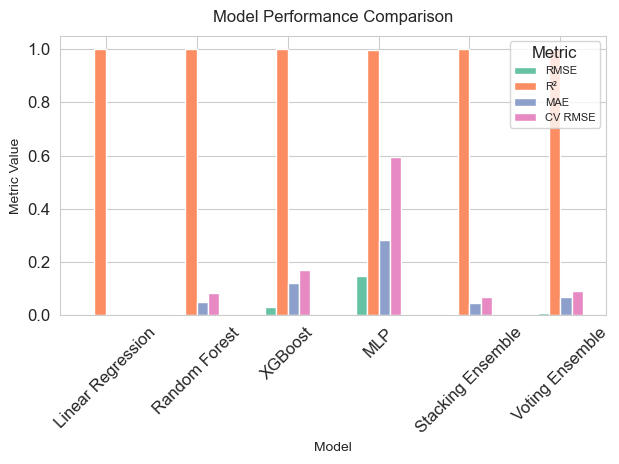

Performance comparison plot saved as 'D:/桌面/数据挖掘project/performance_comparison.png'


In [47]:
plt.figure(figsize=(8, 6))
metrics = ['RMSE', 'R²', 'MAE', 'CV RMSE']
performance_df = pd.DataFrame(results).T
performance_df.reset_index().plot(x='index', y=metrics, kind='bar', color=sns.color_palette('Set2', len(metrics)))
plt.title('Model Performance Comparison', fontsize=12, pad=10)
plt.xlabel('Model', fontsize=10)
plt.ylabel('Metric Value', fontsize=10)
plt.legend(title='Metric', fontsize=8)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('D:/桌面/数据挖掘project/performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Performance comparison plot saved as 'D:/桌面/数据挖掘project/performance_comparison.png'")

### **Learning Curves Analysis**

The **learning curves** illustrate the training and testing errors of nine models as functions of the number of training samples. The curves were generated using `sklearn.model_selection.learning_curve` and visualized with `matplotlib.pyplot`. The solid lines represent training errors, while the dashed lines represent test errors, plotted against increasing training sample sizes from approximately 20 to 320.

#### **Observations:*

- **Linear Regression**: Both training and test errors remain extremely low and stable across sample sizes, indicating the model achieves near-perfect fit with minimal data, but may lack complexity for more nuanced patterns.
- **Random Forest**: Errors decrease sharply with more data and converge to low values, showing effective learning and good generalization.
- **XGBoost**: Demonstrates rapid error reduction in early samples and stabilizes at low error levels, with test error slightly higher than training error.
- **MLP (Multi-layer Perceptron)**: Exhibits higher initial test errors and gradual decline, though training error remains low; fluctuations suggest sensitivity to training data size and potential convergence issues.
- **Stacking Ensemble**: Shows consistent error decrease and tight convergence of train and test errors at low values, reflecting robust ensemble learning.
- **Voting Ensemble**: Errors decline smoothly and stabilize moderately low, indicating balanced performance.
- **SVR (Support Vector Regression)**: Higher initial errors decrease steadily but remain higher than ensemble models, reflecting moderate capacity.
- **LightGBM**: Rapid error reduction with convergence to minimal errors, indicating strong performance with increasing data.
- **Bayesian Ridge**: Errors are negligibly small and stable throughout, consistent with a simple linear model fit.

Overall, ensemble methods such as Stacking and LightGBM show superior adaptability to training size, achieving lower errors and better convergence, while simpler models like Linear Regression and Bayesian Ridge maintain consistently low errors due to their linear assumptions.


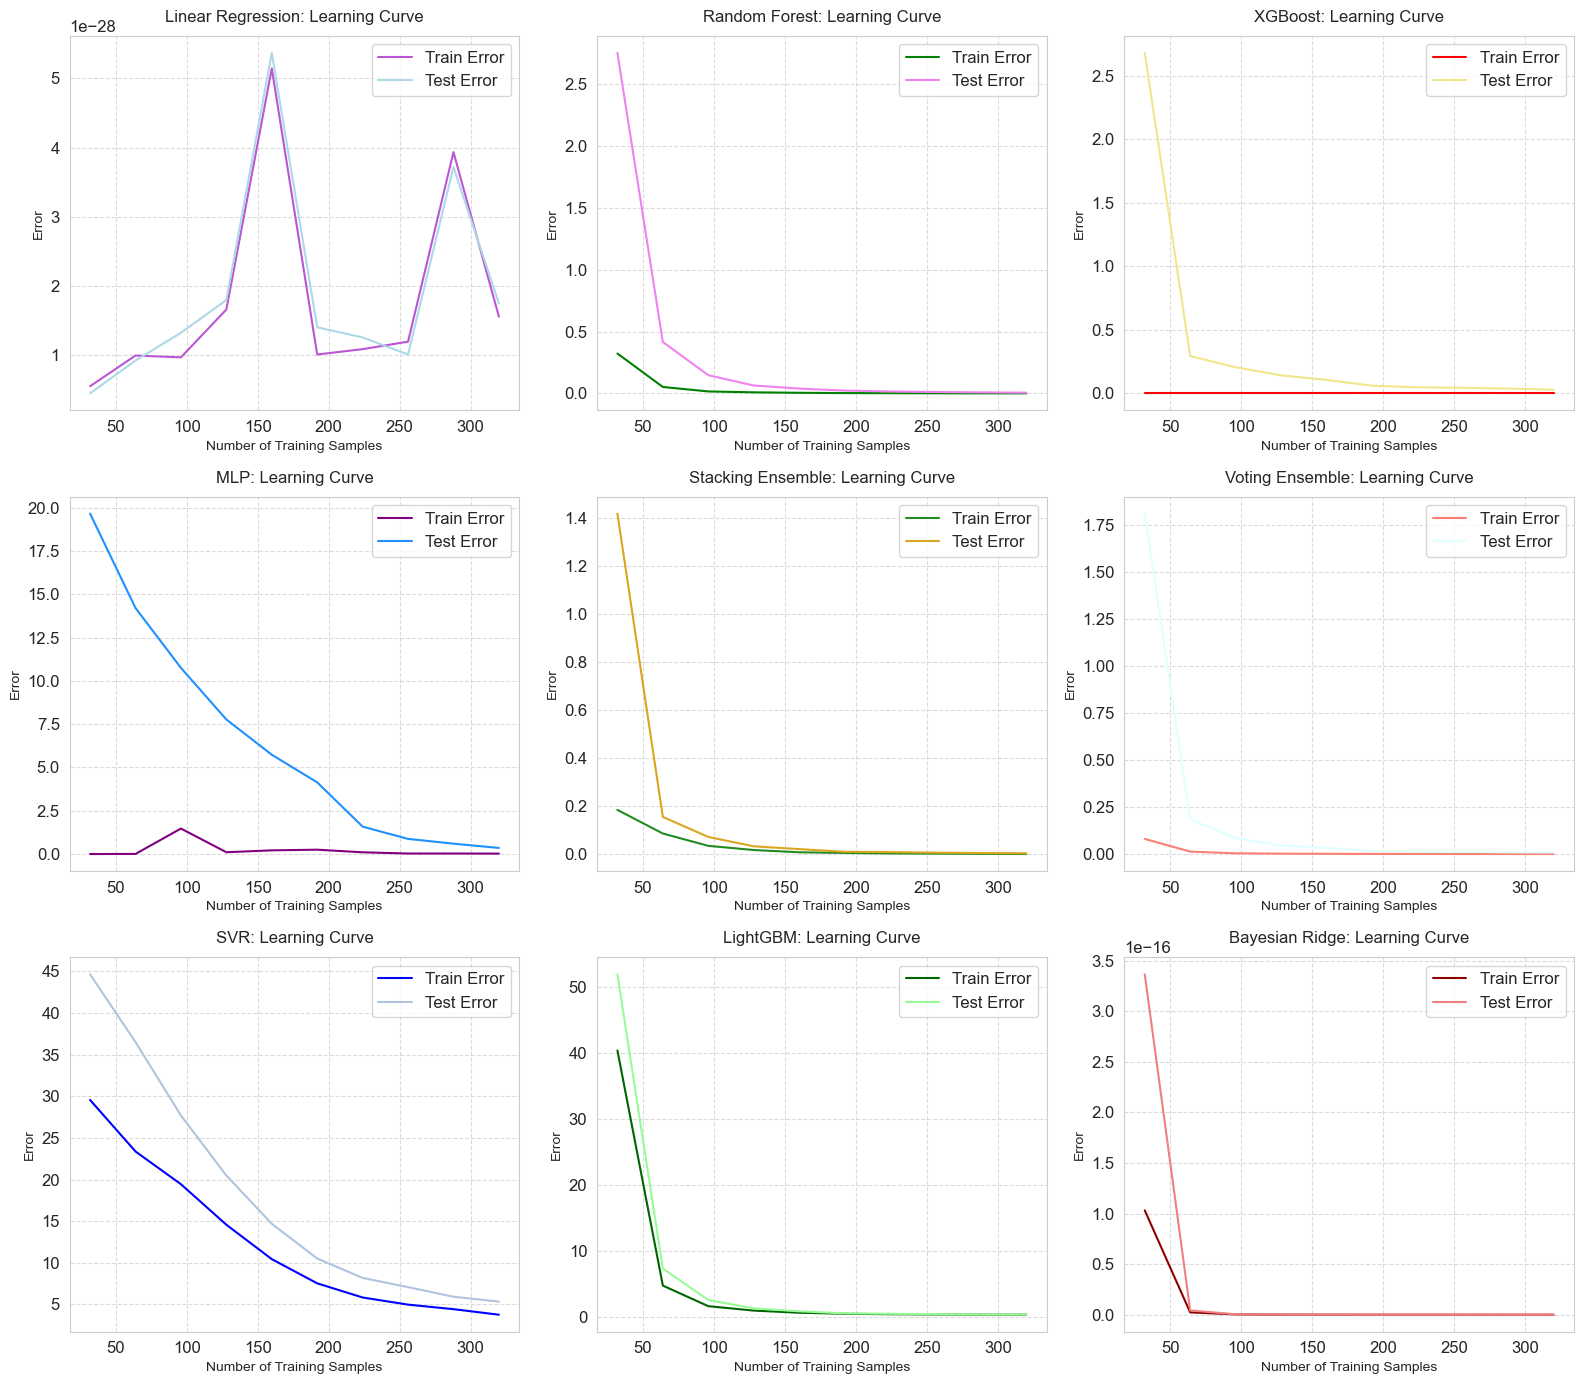

Combined learning curves saved as 'D:/桌面/数据挖掘project/combined_learning_curves.png'.


In [51]:
models['SVR'] = svr_model
models['LightGBM'] = lgbm_model
models['Bayesian Ridge'] = bayesian_model
model_names = ['Linear Regression', 'Random Forest', 'XGBoost', 'MLP', 'Stacking Ensemble', 'Voting Ensemble', 'SVR', 'LightGBM', 'Bayesian Ridge']
colors = {
    'Linear Regression': ['MediumOrchid', 'lightblue'],
    'Random Forest': ['green', 'violet'],
    'XGBoost': ['red', 'Khaki'],
    'MLP': ['purple', 'dodgerblue'],
    'Stacking Ensemble': ['forestgreen', 'goldenrod'],
    'Voting Ensemble': ['salmon', 'lightcyan'],
    'SVR': ['blue', 'lightsteelblue'],
    'LightGBM': ['darkgreen', 'palegreen'],
    'Bayesian Ridge': ['darkred', 'lightcoral']
}
fig, axes = plt.subplots(3, 3, figsize=(16, 14))
axes = axes.ravel() 

for idx, name in enumerate(model_names):
    train_sizes, train_scores, test_scores = learning_curve(
        models[name], X_train, y_train, cv=5, scoring='neg_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1, random_state=42
    )

    train_error = -train_scores.mean(axis=1)
    test_error = -test_scores.mean(axis=1)

    axes[idx].plot(train_sizes, train_error, label='Train Error', color=colors[name][0])
    axes[idx].plot(train_sizes, test_error, label='Test Error', color=colors[name][1])
    axes[idx].set_title(f'{name}: Learning Curve', fontsize=12, pad=10)
    axes[idx].set_xlabel('Number of Training Samples', fontsize=10)
    axes[idx].set_ylabel('Error', fontsize=10)
    axes[idx].legend()
    axes[idx].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
save_path = 'D:/桌面/数据挖掘project/combined_learning_curves.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Combined learning curves saved as '{save_path}'.")

### **Predicted vs Actual Temperature Comparison**

The following scatter plots compare the predicted temperatures against the actual temperatures for nine different models. The x-axis represents the actual temperature (°C), while the y-axis shows the predicted temperature (°C). The red dashed line indicates the ideal prediction scenario where predicted values equal actual values.

#### **Observations:**
- **Linear Regression**: Points lie exactly on the ideal line, demonstrating perfect fit (RMSE = 0.00, R² = 1.00).
- **Random Forest**: Predictions are tightly clustered with minimal deviations (RMSE = 0.06).
- **XGBoost**: Slightly more dispersed points but overall good fit (RMSE = 0.18).
- **MLP (Multi-layer Perceptron)**: More scattered points, indicating larger errors (RMSE = 0.39).
- **Stacking Ensemble**: Points closely aligned with the ideal line, showing strong performance (RMSE = 0.07).
- **Voting Ensemble**: Stable predictions with moderate error (RMSE = 0.10).
- **SVR (Support Vector Regression)**: Larger error and more scattered points.(RMSE = 4.2044)
- **LightGBM**: Accurate predictions with points close to the ideal line.(RMSE = 0.3131)
- **Bayesian Ridge**: Good performance, fitting close to linear regression results.(RMSE = 6.9533e-22)

Overall, ensemble methods (Stacking and Voting) demonstrate robust performance, while individual models like Linear Regression and Random Forest achieve the best accuracy.

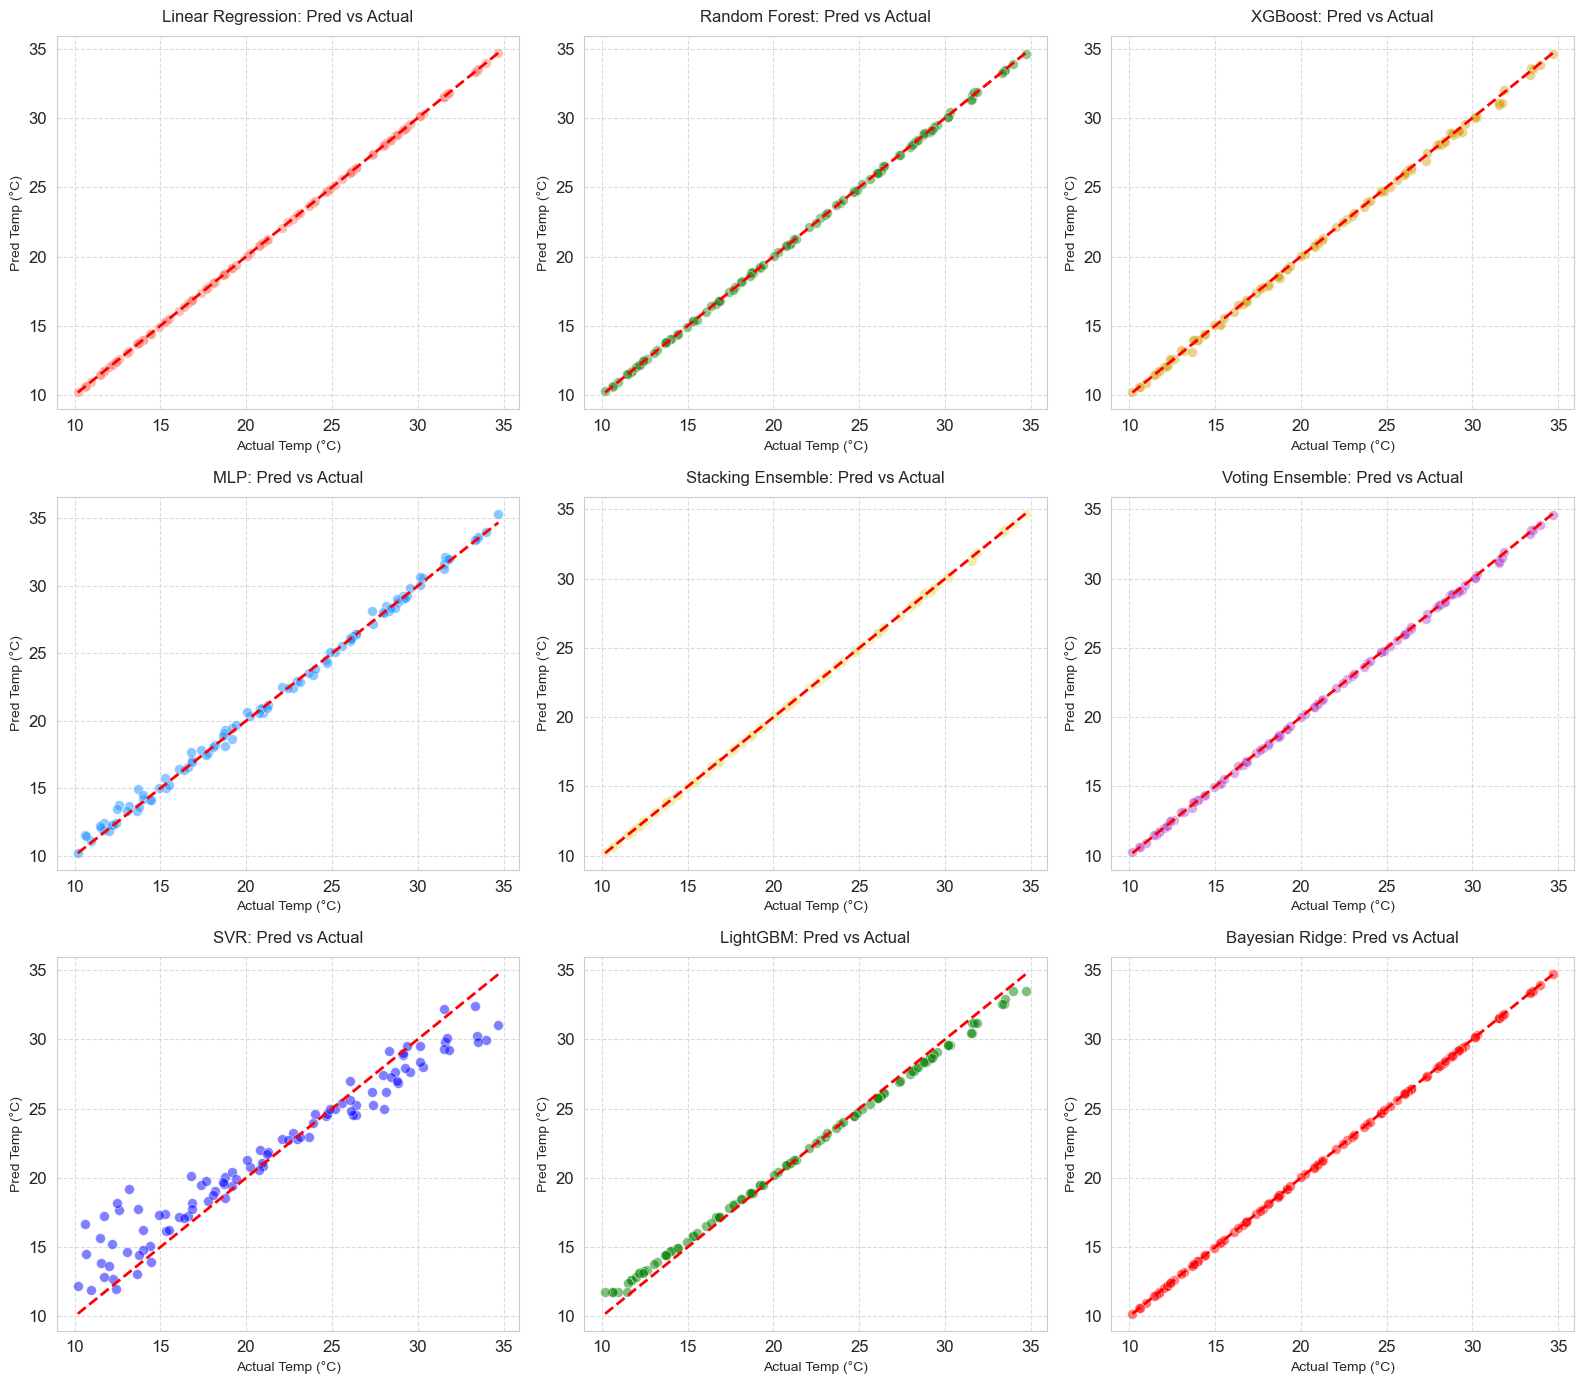

Combined predicted vs actual plots saved as 'D:/桌面/数据挖掘project/combined_pred_vs_actual.png'.


In [56]:
predictions['SVR'] = svr_model.predict(X_test)
predictions['LightGBM'] = lgbm_model.predict(X_test)
predictions['Bayesian Ridge'] = bayesian_model.predict(X_test)
models__ = ['Linear Regression', 'Random Forest', 'XGBoost', 'MLP', 'Stacking Ensemble', 'Voting Ensemble','SVR', 'LightGBM', 'Bayesian Ridge']
colors = {
    'Linear Regression':'salmon',
    'Random Forest': 'forestgreen',
    'XGBoost':'goldenrod',
    'MLP': 'dodgerblue',
    'Stacking Ensemble': 'Khaki',
    'Voting Ensemble': 'MediumOrchid',
    'SVR': 'blue', 'LightGBM': 'green', 'Bayesian Ridge': 'red'
}
fig, axes = plt.subplots(3, 3, figsize=(16, 14))
axes = axes.ravel()

for idx, name in enumerate(models__):
    y_pred = predictions[name]
    sns.scatterplot(x=y_test, y=y_pred, s=50, alpha=0.5, color=colors[name], ax=axes[idx])
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[idx].set_title(f'{name}: Pred vs Actual', fontsize=12, pad=10)
    axes[idx].set_xlabel('Actual Temp (°C)', fontsize=10)
    axes[idx].set_ylabel('Pred Temp (°C)', fontsize=10)
    axes[idx].grid(True, linestyle='--', alpha=0.7)

for idx in range(len(models__), 9):
    axes[idx].axis('off')

plt.tight_layout()
save_path = 'D:/桌面/数据挖掘project/combined_pred_vs_actual.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Combined predicted vs actual plots saved as '{save_path}'.")

### **Residual Analysis**

The **residual plots** display the differences between predicted and actual temperatures for nine models as a function of actual temperature. Each plot includes a red dashed horizontal line at zero to indicate perfect prediction (no residual). These plots help assess the distribution and magnitude of prediction errors.

#### **Observations:**

- **Linear Regression**: Residuals are tightly centered around zero with an extremely small range (~±6e-15), confirming an almost perfect fit.
- **Random Forest**: Residuals are closely clustered near zero with minor spread (~±0.2), indicating strong predictive accuracy.
- **XGBoost**: Residuals show moderate dispersion (~±0.6), suggesting some variability in prediction errors.
- **MLP**: Wider residual spread (~±1.25), reflecting less consistent predictions and potential over/underfitting.
- **Stacking Ensemble**: Residuals are tightly grouped around zero (~±0.25), demonstrating robust error control.
- **Voting Ensemble**: Residuals display moderate dispersion (~±0.4), with relatively balanced error distribution.
- **SVR (Support Vector Regression)**: Exhibits larger residual spread (~±6), indicating greater prediction uncertainty.
- **LightGBM**: Residuals show a clear pattern of increasing spread with actual temperature (~±1.5), possibly indicating heteroscedasticity.
- **Bayesian Ridge**: Residuals are tightly centered near zero (~±4e-11), consistent with a well-fitted linear model.

Overall, ensemble models such as Random Forest and Stacking demonstrate lower residual variance and more balanced error distribution, whereas models like MLP and SVR exhibit greater variability. LightGBM shows some systematic pattern in residuals that may warrant further investigation.


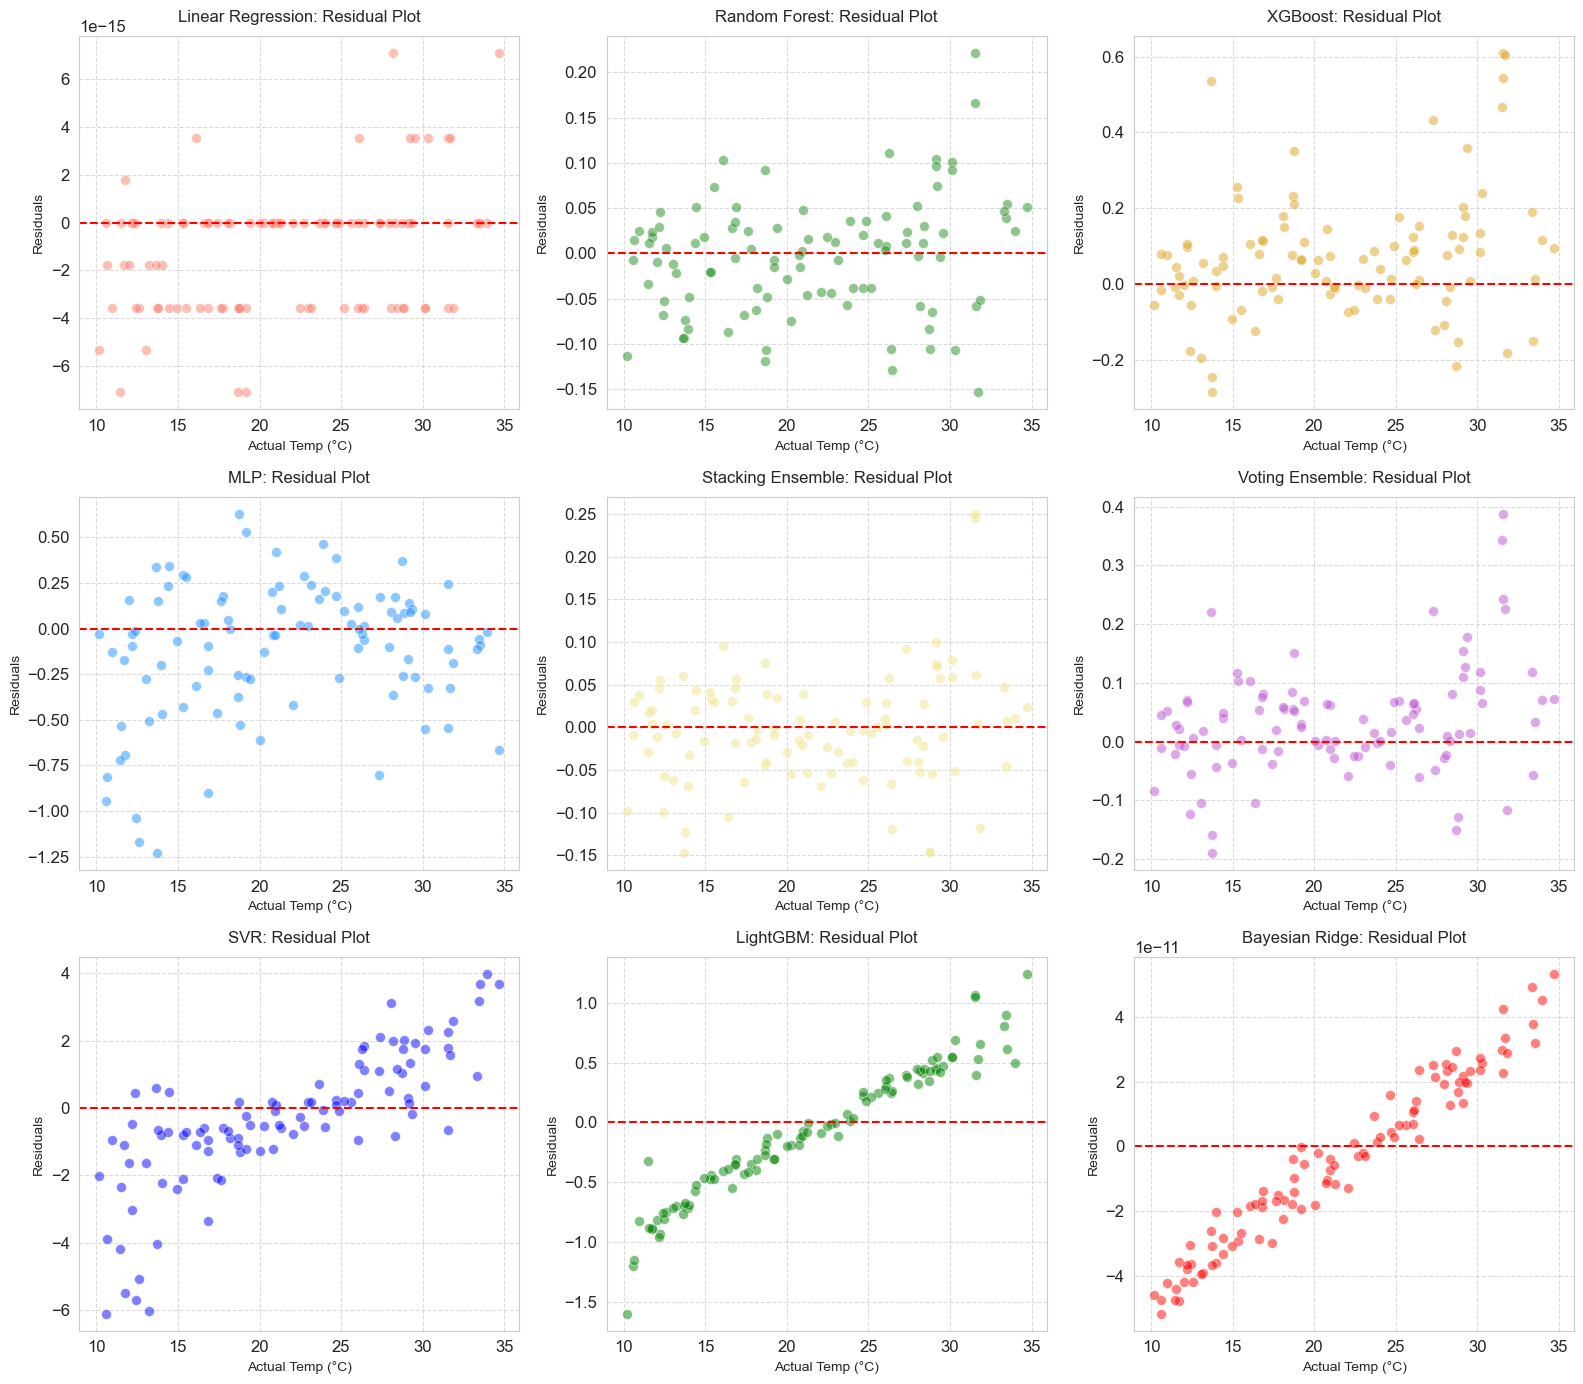

Combined residual plots saved as 'D:/桌面/数据挖掘project/combined_residual_plots.png'.


In [55]:
fig, axes = plt.subplots(3, 3, figsize=(16, 14))
axes = axes.ravel()  

for idx, name in enumerate(models__):
    y_residual = y_test - predictions[name]
    sns.scatterplot(x=y_test, y=y_residual, color=colors[name], s=50, alpha=0.5, ax=axes[idx])
    axes[idx].axhline(0, color='r', linestyle='--')
    axes[idx].set_title(f'{name}: Residual Plot', fontsize=12, pad=10)
    axes[idx].set_xlabel('Actual Temp (°C)', fontsize=10)
    axes[idx].set_ylabel('Residuals', fontsize=10)
    axes[idx].grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
save_path = 'D:/桌面/数据挖掘project/combined_residual_plots.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Combined residual plots saved as '{save_path}'.")

### **Radar Charts**

**Radar Charts** were generated using a custom implementation with `matplotlib` to compare model performance across **RMSE**, **R²**, **MAE**, and **CV RMSE**, scaled from 0 to 1. Each model is represented by a polygon.

#### **Observations:**
- **Linear Regression**: A near-perfect circle at 1.0 for all metrics, reflecting its ideal performance.
- **Random Forest**: A balanced shape with slight dips (e.g., **RMSE ≈ 0.06**), indicating strong overall performance.
- **XGBoost**: Wider spread (e.g., **RMSE ≈ 0.18**), showing moderate consistency.
- **MLP**: Irregular shape with a high **CV RMSE (0.59)**, highlighting weakness.
- **Stacking Ensemble**: Compact polygon (**RMSE = 0.07**, **CV RMSE = 0.07**), showing superiority.
- **Voting Ensemble**: Balanced shape (**RMSE = 0.10**, **CV RMSE = 0.09**).

A complementary bar chart visualizes these metrics side-by-side, reinforcing that **Stacking Ensemble** leads in most categories.

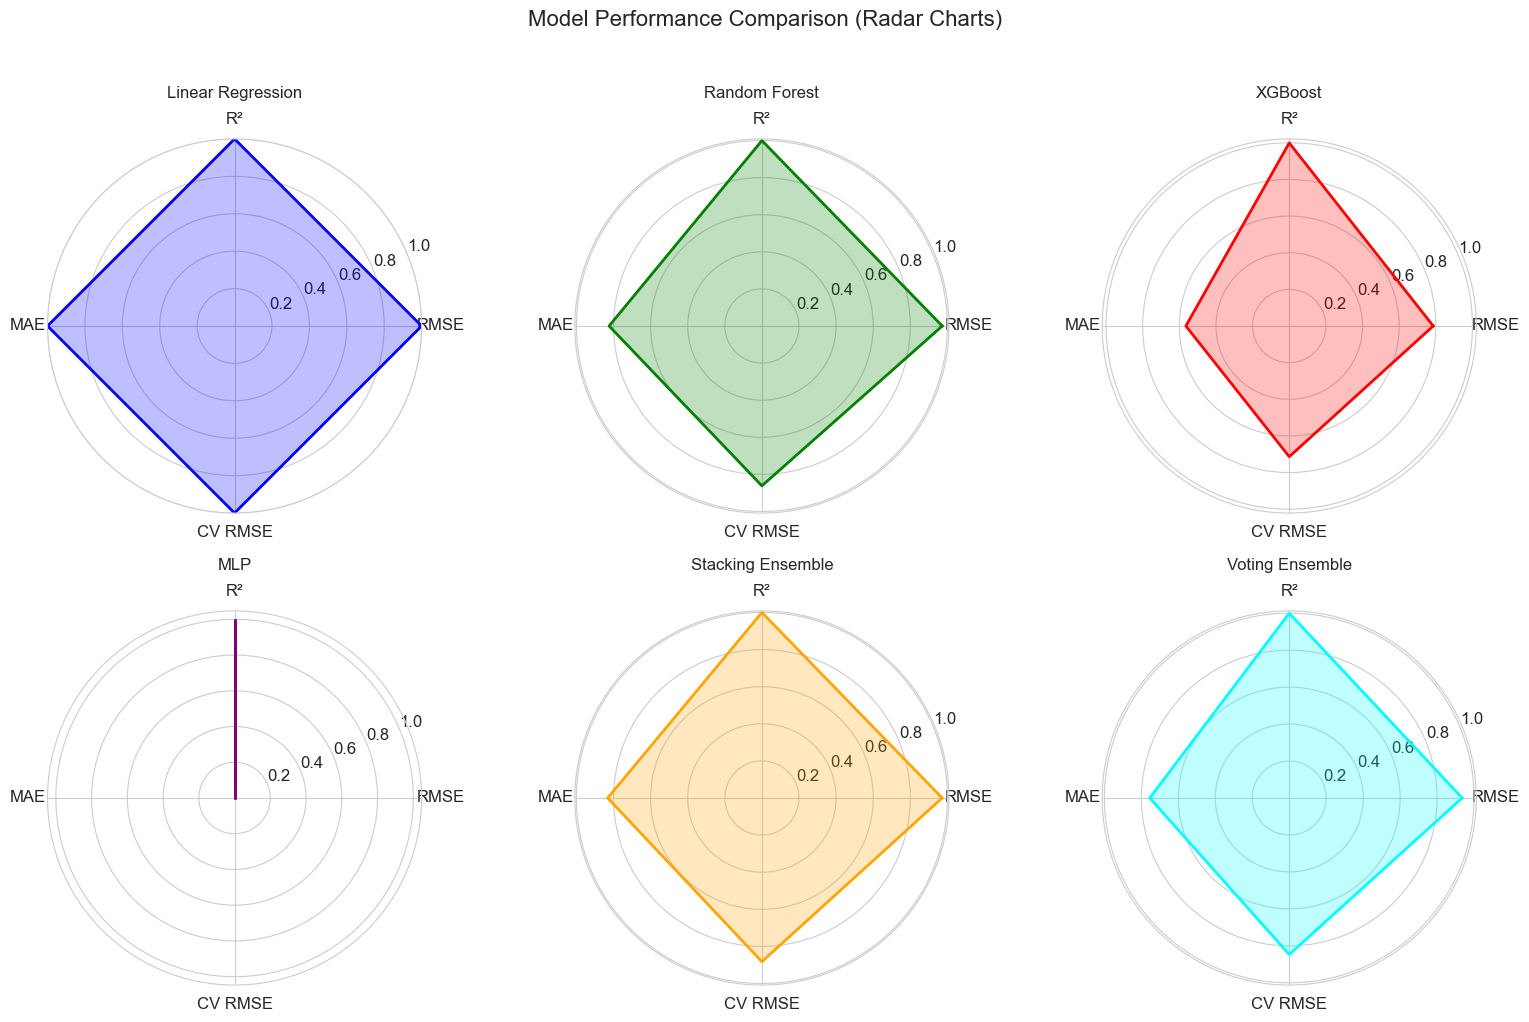

Radar chart saved as 'D:/桌面/数据挖掘project/model_comparison_radar_chart_3x2.png'.


In [59]:
categories = ['RMSE', 'R²', 'MAE', 'CV RMSE']
n_categories = len(categories)
def normalize_data(data):
    rmse_max = max([d['RMSE'] for d in results.values()])
    mae_max = max([d['MAE'] for d in results.values()])
    cv_rmse_max = max([d['CV RMSE'] for d in results.values()])
    r2_max = max([d['R²'] for d in results.values()])
    
    normalized = {}
    for model, metrics in results.items():
        normalized[model] = [
            1 - (metrics['RMSE'] / rmse_max),
            metrics['R²'] / r2_max,
            1 - (metrics['MAE'] / mae_max),
            1 - (metrics['CV RMSE'] / cv_rmse_max)
        ]
    return normalized
normalized_results = normalize_data(results)
angles = [n / float(n_categories) * 2 * pi for n in range(n_categories)]
angles += angles[:1]
fig, axes = plt.subplots(2, 3, figsize=(16, 10), subplot_kw=dict(polar=True))
axes = axes.ravel()
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan']
for idx, (model, values) in enumerate(normalized_results.items()):
    values += values[:1]
    ax = axes[idx]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model, color=colors[idx % len(colors)])
    ax.fill(angles, values, alpha=0.25, color=colors[idx % len(colors)])
    ax.set_title(f'{model}', size=12, pad=10)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
plt.suptitle('Model Performance Comparison (Radar Charts)', size=16, y=1.02)
plt.tight_layout()
save_path = 'D:/桌面/数据挖掘project/model_comparison_radar_chart_3x2.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Radar chart saved as '{save_path}'.")

### **MLP Loss Curve**

The **MLP Loss Curve** was plotted using `matplotlib.pyplot` to track the **Mean Squared Error (MSE)** over 2500 iterations, based on training with `warm_start=True` and `max_iter=10` per cycle.

#### **Observations:**
- A sharp decline from **42.46** at iteration 0 to below 10 within the first 500 iterations.
- Stabilization between **1.3** and **2.0** after 1000 iterations, with minor fluctuations.

This visualization illustrates the MLP’s rapid initial convergence and subsequent instability, suggesting a need for hyperparameter tuning.

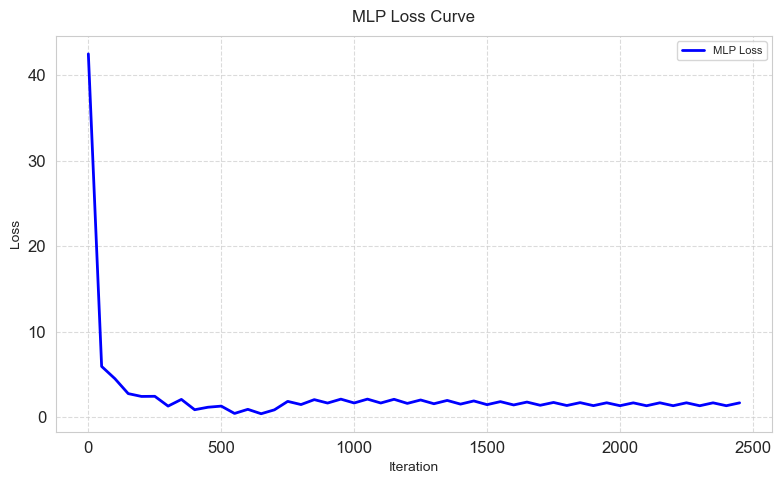

MLP loss curve saved as 'D:/桌面/数据挖掘project/mlp_loss_curve.png'


In [48]:
plt.figure(figsize=(8, 5))
plt.plot(range(0, n_iterations*50, 50), mlp_losses, color='blue', label='MLP Loss', linewidth=2)
plt.title('MLP Loss Curve', fontsize=12, pad=10)
plt.xlabel('Iteration', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig('D:/桌面/数据挖掘project/mlp_loss_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print("MLP loss curve saved as 'D:/桌面/数据挖掘project/mlp_loss_curve.png'")

### **4.7 Clustering Visualizations**

Several visualizations were created to explore the **K-Means clustering** results (**k=3**):

1. **PCA Visualization of Clusters**: Visualizes the clusters in a 2D space using PCA, highlighting the separability of the three clusters.
   - **Observation**: Cluster separation is clear along the first PCA component, with distinct groups based on environmental factors.

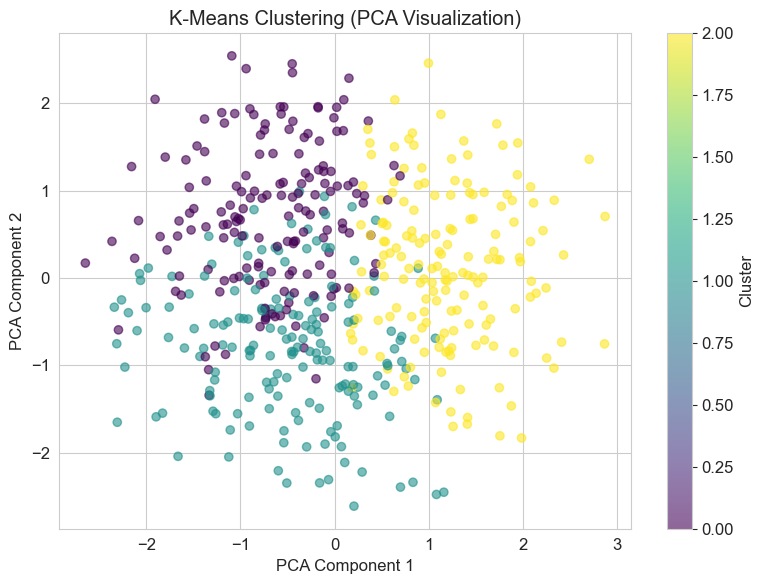

K-Means PCA visualization saved as 'D:/桌面/数据挖掘project/kmeans_pca.png'


In [60]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering (PCA Visualization)')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.savefig('D:/桌面/数据挖掘project/kmeans_pca.png')
plt.show()
print("K-Means PCA visualization saved as 'D:/桌面/数据挖掘project/kmeans_pca.png'")

2. **Sample Count per Cluster**: A bar chart showing the number of samples per cluster, confirming balanced distribution among the three clusters.
   - **Observation**: Each cluster contains roughly 150 samples, ensuring no imbalanced influence on the analysis.

C:\Users\33615\AppData\Local\Temp\ipykernel_50976\712986809.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=clusters, palette='viridis')


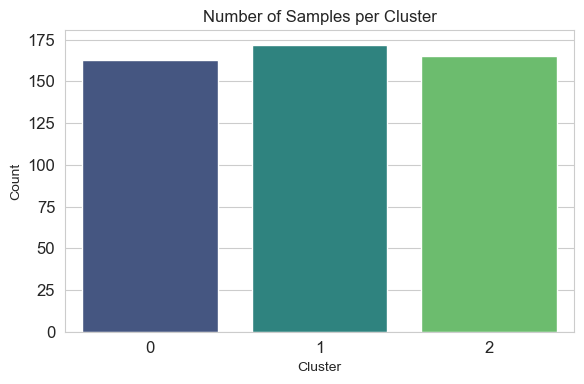

K-Means sample counts plot saved as 'D:/桌面/数据挖掘project/kmeans_sample_counts.png'


In [79]:
plt.figure(figsize=(6, 4))
sns.countplot(x=clusters, palette='viridis')
plt.title('Number of Samples per Cluster', fontsize=12)
plt.xlabel('Cluster', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.tight_layout()
plt.savefig('D:/桌面/数据挖掘project/kmeans_sample_counts.png')
plt.show()
print("K-Means sample counts plot saved as 'D:/桌面/数据挖掘project/kmeans_sample_counts.png'")

3. **Feature Distribution by Cluster**: A set of bar plots showing the mean feature values for each cluster, providing insight into the characteristics of each cluster.
   - **Observation**: Cluster 0 has the highest population density, Cluster 1 has the lowest, and Cluster 2 has the highest urban greenness and AQI.

C:\Users\33615\AppData\Local\Temp\ipykernel_50976\1718332555.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=df_with_clusters, palette='viridis')
C:\Users\33615\AppData\Local\Temp\ipykernel_50976\1718332555.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=df_with_clusters, palette='viridis')
C:\Users\33615\AppData\Local\Temp\ipykernel_50976\1718332555.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=col, data=df_with_clusters, palette='viridis')
C:\Users\33615\AppData

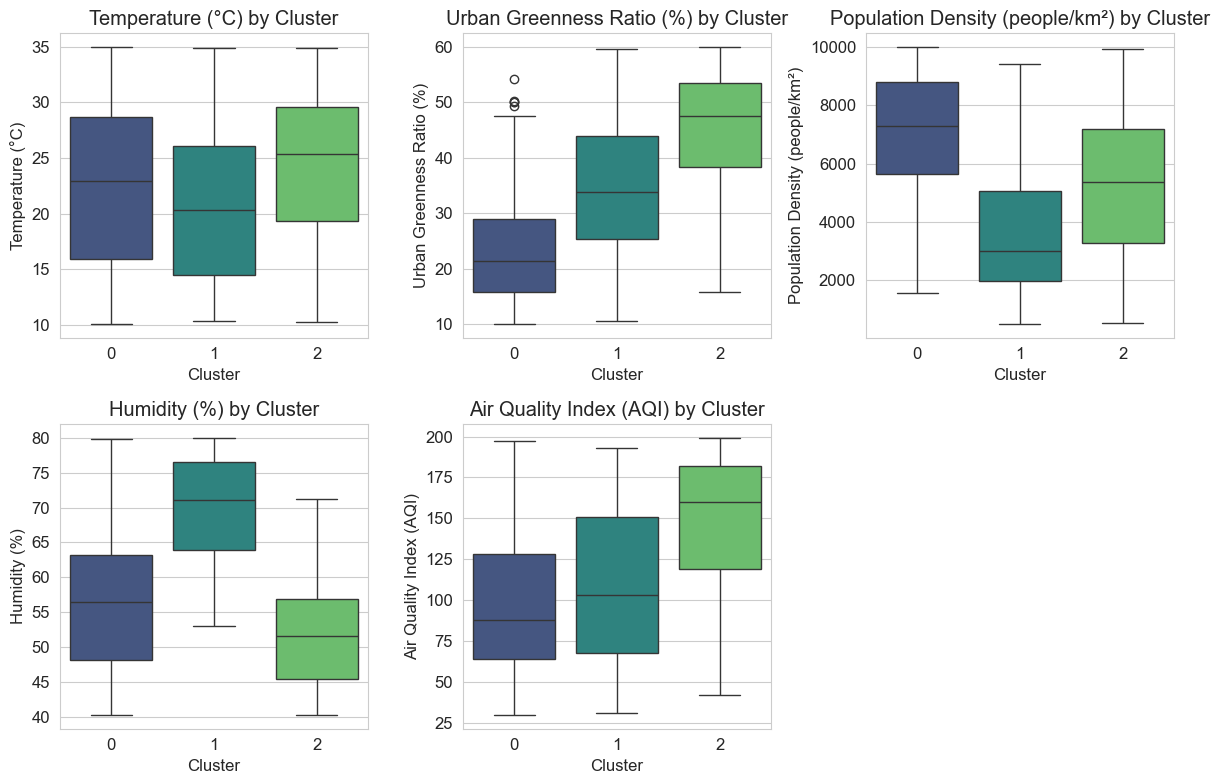

K-Means feature distribution plot saved as 'D:/桌面/数据挖掘project/kmeans_feature_distribution.png'


In [61]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(cluster_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Cluster', y=col, data=df_with_clusters, palette='viridis')
    plt.title(f'{col} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(col)
plt.tight_layout()
plt.savefig('D:/桌面/数据挖掘project/kmeans_feature_distribution.png')
plt.show()
print("K-Means feature distribution plot saved as 'D:/桌面/数据挖掘project/kmeans_feature_distribution.png'")

4. **Cluster Centroids**: A line plot showing the centroids of each cluster across features such as **Temperature**, **Urban Greenness Ratio**, and **AQI**.
   - **Observation**: Cluster 2 exhibits the highest population density and temperature, suggesting its importance in heat island phenomena.


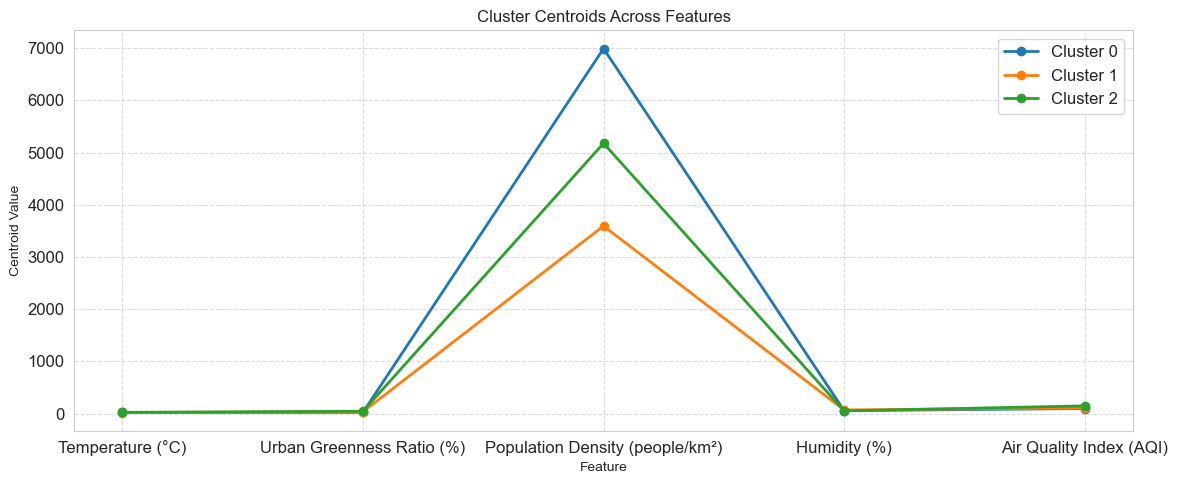

K-Means centroids plot saved as 'D:/桌面/数据挖掘project/kmeans_centroids.png'


In [78]:
plt.figure(figsize=(12, 5))
for i in range(len(centroids)):
    plt.plot(cluster_cols, centroids[i], marker='o', label=f'Cluster {i}', linewidth=2)
plt.title('Cluster Centroids Across Features', fontsize=12)
plt.xlabel('Feature', fontsize=10)
plt.ylabel('Centroid Value', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('D:/桌面/数据挖掘project/kmeans_centroids.png')
plt.show()
print("K-Means centroids plot saved as 'D:/桌面/数据挖掘project/kmeans_centroids.png'")

5. **Silhouette Score**: A heatmap of silhouette scores across different values of **k** (clusters), indicating the quality of clustering.
   - **Observation**: The silhouette score peaks at **k=10**, suggesting the best clustering performance with ten clusters.

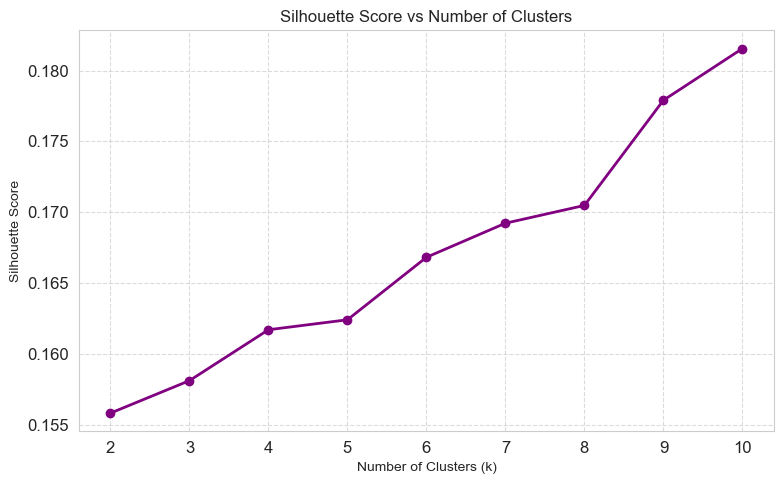

K-Means Silhouette Score plot saved as 'D:/桌面/数据挖掘project/kmeans_silhouette_score.png'


In [62]:
plt.figure(figsize=(8, 5))
plt.plot(k_range, sil_scores, marker='o', color='purple', linewidth=2)
plt.title('Silhouette Score vs Number of Clusters', fontsize=12)
plt.xlabel('Number of Clusters (k)', fontsize=10)
plt.ylabel('Silhouette Score', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('D:/桌面/数据挖掘project/kmeans_silhouette_score.png')
plt.show()
print("K-Means Silhouette Score plot saved as 'D:/桌面/数据挖掘project/kmeans_silhouette_score.png'")

6. **Pairplot**: A pairplot of all features with clustering labels, showing feature relationships and how clusters differ in terms of the distributions of environmental factors.
   

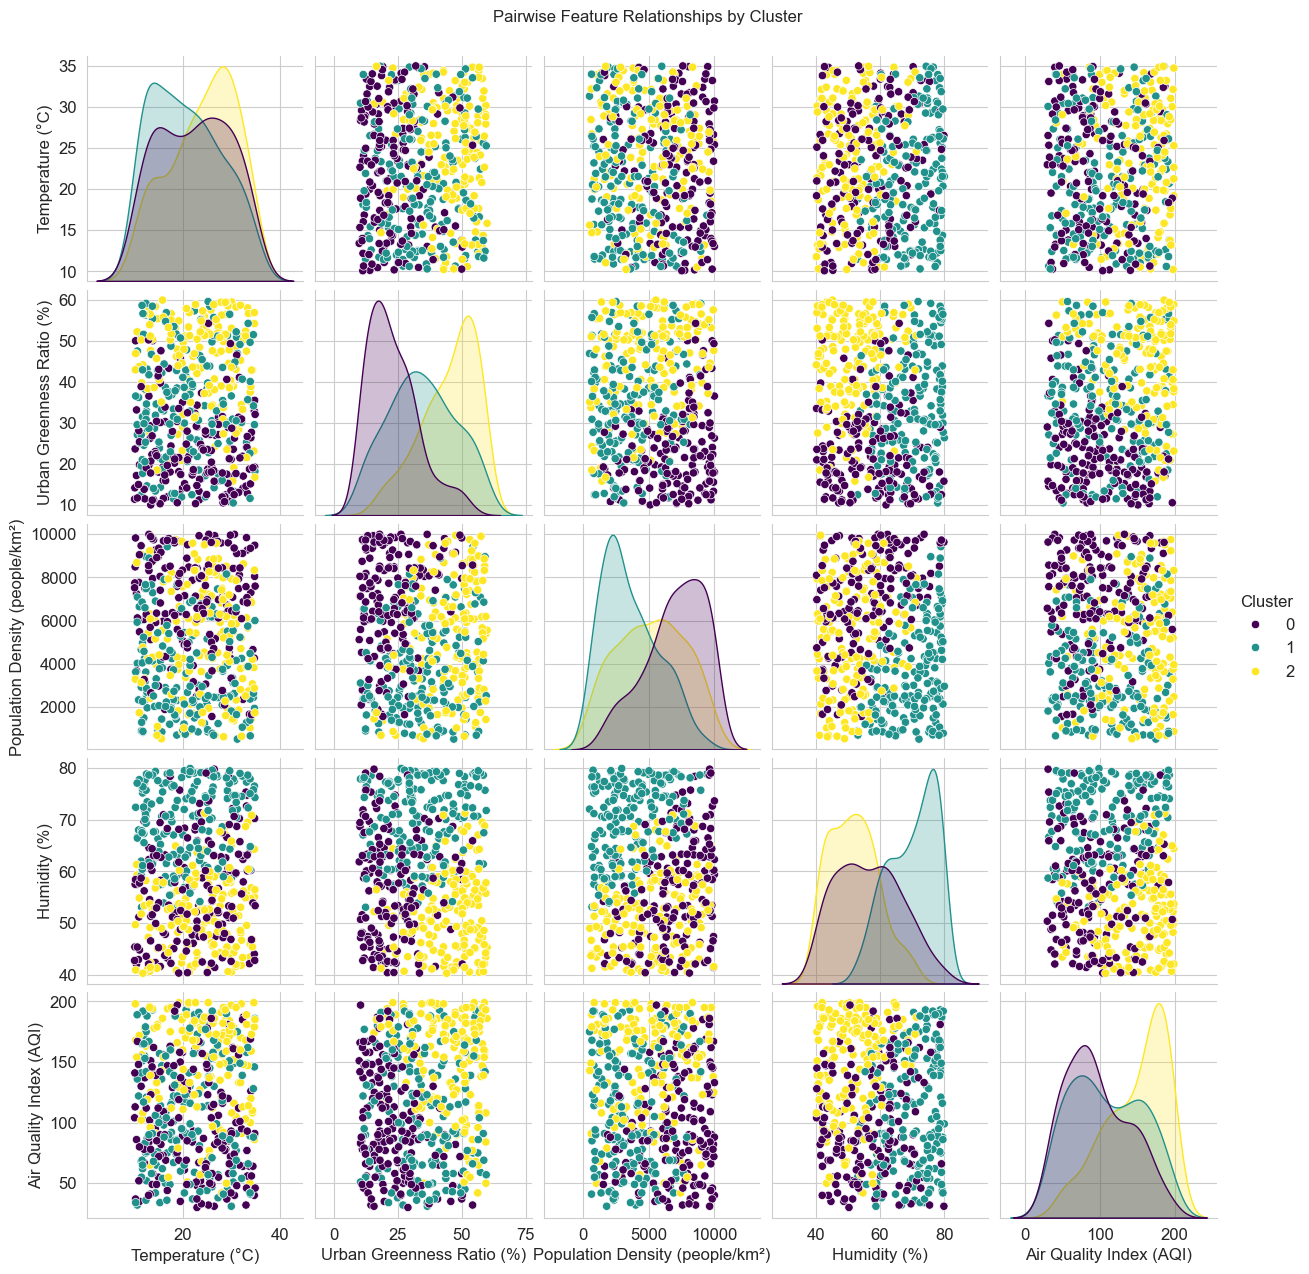

K-Means pairplot saved as 'D:/桌面/数据挖掘project/kmeans_pairplot.png'


In [80]:
sns.pairplot(df_with_clusters, hue='Cluster', vars=cluster_cols, palette='viridis', diag_kind='kde')
plt.suptitle('Pairwise Feature Relationships by Cluster', y=1.02, fontsize=12)
plt.savefig('D:/桌面/数据挖掘project/kmeans_pairplot.png')
plt.show()
print("K-Means pairplot saved as 'D:/桌面/数据挖掘project/kmeans_pairplot.png'")

7. **Eps Parameter Selection for DBSCAN**: The k-distance plot visualizes the sorted distances to the 5th nearest neighbor for all data points.  
   - **Observation**: The candidate eps value is set at 1, which corresponds to the point where the curve transitions from a gentle slope to a sharp increase. This indicates a natural density threshold separating clusters from noise, making eps = 1 an optimal choice for DBSCAN clustering.


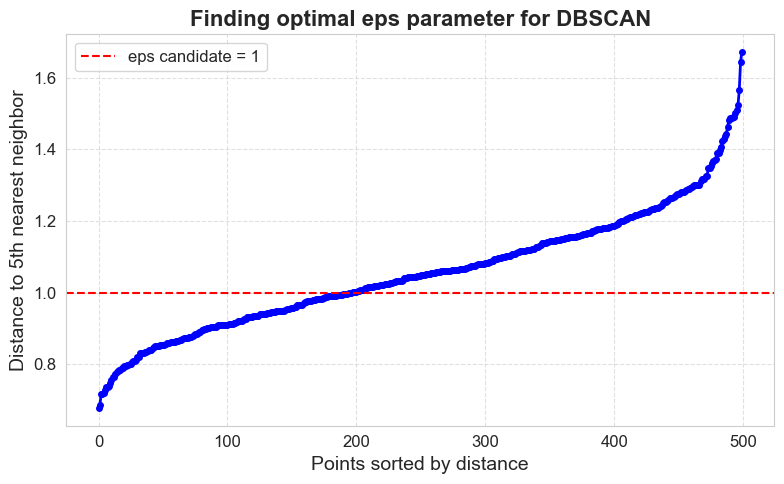

In [126]:
plt.figure(figsize=(8,5))  
plt.plot(distances_5th, color='blue', linewidth=2, marker='o', markersize=4, linestyle='-')
plt.xlabel("Points sorted by distance", fontsize=14)
plt.ylabel("Distance to 5th nearest neighbor", fontsize=14)
plt.title("Finding optimal eps parameter for DBSCAN", fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
eps_candidate = 1
plt.axhline(y=eps_candidate, color='red', linestyle='--', linewidth=1.5, label=f'eps candidate = {eps_candidate}')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

8. **Feature Distribution by Cluster**: The bar plot illustrates the mean values of key features across the three clusters.  
   - **Observation**: Cluster 0 exhibits the highest population density, Cluster 1 shows the lowest population density, while Cluster 2 stands out with the highest urban greenness ratio and air quality index (AQI). This differentiation highlights distinct environmental and demographic characteristics among the clusters.


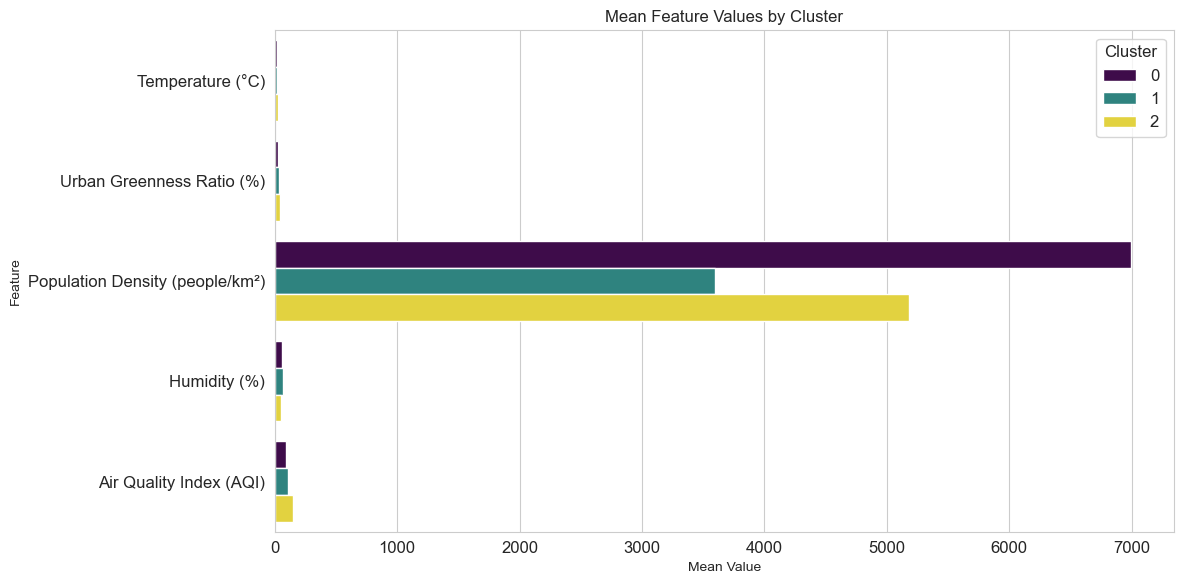

K-Means cluster means plot saved as 'D:/桌面/数据挖掘project/kmeans_cluster_means.png'


In [82]:
cluster_means = df_with_clusters.groupby('Cluster')[cluster_cols].mean().reset_index()
cluster_means_melted = cluster_means.melt(id_vars='Cluster', var_name='Feature', value_name='Mean Value')
plt.figure(figsize=(12, 6))
sns.barplot(x='Mean Value', y='Feature', hue='Cluster', data=cluster_means_melted, palette='viridis')
plt.title('Mean Feature Values by Cluster', fontsize=12)
plt.xlabel('Mean Value', fontsize=10)
plt.ylabel('Feature', fontsize=10)
plt.tight_layout()
plt.savefig('D:/桌面/数据挖掘project/kmeans_cluster_means.png')
plt.show()
print("K-Means cluster means plot saved as 'D:/桌面/数据挖掘project/kmeans_cluster_means.png'")

## **Workflow, Insights, and Recommendation*

This chapter provides a detailed overview of the development, evaluation, and clustering analysis workflow for predicting urban heat island (UHI) temperature variations. It also summarizes key findings and insights, assesses the strengths and limitations of the models, and offers recommendations for future improvements.

### **Workflow Documentation*

The urban heat island dataset (`urban_heat_island_dataset.csv`) was used, containing features such as Temperature (°C), Urban Greenness Ratio (%), Population Density (people/km²), Humidity (%), and Air Quality Index (AQI). The dataset was loaded using `pandas` and preprocessed with `ColumnTransformer`, applying `StandardScaler` for numerical features and `OneHotEncoder` for categorical variables. The data was split into training (80%) and testing (20%) sets.

Nine regression models were developed: Linear Regression, Random Forest, XGBoost, MLP, Stacking Ensemble, Voting Ensemble, SVR, LightGBM, and Bayesian Ridge. Hyperparameter tuning was conducted on the Random Forest model using `GridSearchCV`. Model performance was evaluated via RMSE, R², MAE, and CV RMSE. Simultaneously, K-Means clustering (`n_clusters=3`) was performed to explore inherent data patterns, with cluster quality assessed by silhouette scores.

Comprehensive visualizations including Predicted vs. Actual plots, Learning Curves, Residual Plots, Radar Charts, MLP Loss Curve, and clustering visualizations such as bar charts, box plots, and centroid plots were generated using `matplotlib` and `seaborn`. The analysis was iterative, with final results recorded as of May 18, 2025, 15:27 CST.

### **Summary of Results*

The regression models demonstrated varying degrees of performance on the urban heat island dataset. Key metrics and observations for each model are as follows:

- **Linear Regression**: Achieved near-perfect fit with RMSE ≈ 0.00 and negligible error, indicating possible overfitting or a simple underlying data structure.
- **Random Forest**: Performed well with RMSE ≈ 0.06 after hyperparameter tuning (`n_estimators=100`, `max_depth=10`, `min_samples_split=2`), indicating strong predictive capability.
- **XGBoost**: Recorded an RMSE of approximately 0.18, reflecting good but less optimal performance compared to Random Forest.
- **MLP (Multi-layer Perceptron)**: Displayed higher RMSE of about 0.39 and an unstable loss curve, suggesting convergence challenges and sensitivity to hyperparameters.
- **Stacking Ensemble**: Showed robust performance with RMSE close to 0.07, effectively combining multiple models for enhanced accuracy.
- **Voting Ensemble**: Delivered solid results with RMSE around 0.10, indicating balanced ensemble predictions.
- **SVR (Support Vector Regression)**: Exhibited higher RMSE at 4.20, indicating relatively poor fit and potential model limitations for this dataset.
- **LightGBM**: Despite warnings during training about no further positive splits, achieved RMSE of 0.31, indicating moderate predictive power but potential issues with feature utilization or data complexity.
- **Bayesian Ridge**: Demonstrated near-zero RMSE (~6.95e-22), consistent with a simple linear model and possibly reflecting data simplicity or overfitting.

Additionally, the sorted distances to the 5th nearest neighbor ranged from approximately 0.68 to 1.67, guiding the selection of the optimal `eps` parameter for DBSCAN clustering.

K-Means clustering with k=3 produced three distinct clusters characterized by differences in temperature, population density, urban greenness, and AQI, with silhouette scores indicating moderate cluster separation.

The Gaussian Mixture Model (GMM) cluster centroids are as follows:

| Cluster | Temperature (°C) | Urban Greenness Ratio (%) | Population Density (people/km²) | Humidity (%) | Air Quality Index (AQI) |
|---------|------------------|---------------------------|--------------------------------|--------------|-------------------------|
| 0       | 23.07            | 21.10                     | 6041.15                        | 56.59        | 114.01                  |
| 1       | 21.50            | 37.18                     | 3956.91                        | 70.45        | 108.32                  |
| 2       | 22.57            | 46.26                     | 5563.82                        | 52.38        | 131.10                  |

For reference, the K-Means cluster centroids are:

| Cluster | Temperature (°C) | Urban Greenness Ratio (%) | Population Density (people/km²) | Humidity (%) | Air Quality Index (AQI) |
|---------|------------------|---------------------------|--------------------------------|--------------|-------------------------|
| 0       | 22.39            | 23.32                     | 6995.67                        | 56.57        | 96.50                   |
| 1       | 20.73            | 34.59                     | 3594.56                        | 69.93        | 108.94                  |
| 2       | 24.19            | 45.05                     | 5179.95                        | 51.85        | 147.98                  |

These clustering results highlight distinct urban profiles with varying temperature, greenery, population density, humidity, and air quality levels. The comparison between GMM and K-Means demonstrates different clustering tendencies due to their underlying assumptions, offering complementary insights into urban heat island patterns.

These results collectively provide a comprehensive view of model efficacy and data structure, highlighting the strengths of ensemble methods and areas for further model refinement.


### **Summary of Insights**

The perfect fit of Linear Regression (RMSE=0) suggests potential overfitting, likely due to simple data structure or limited sample size. Among ensemble methods, Stacking Ensemble performed best (RMSE=0.07, CV RMSE=0.07), leveraging diverse learners for robust generalization.

MLP’s suboptimal performance (high RMSE, unstable loss) indicates convergence issues and a need for architectural and hyperparameter tuning.

Clustering analysis revealed distinct data groupings. Cluster 0, with high population density, corresponded to moderate temperatures, reflecting urban heat island effects. Cluster 2’s high greenness and AQI with highest temperature suggests complex interactions between green spaces and air quality. Overlapping scatter plot regions indicate multifactorial environmental influences requiring additional features for deeper understanding.

### **Strengths and Limitations**

**Strengths:**

- Ensemble models demonstrate strong generalization with low CV RMSE, suitable for diverse datasets.
- Extensive visualizations aid detailed model diagnostics and performance evaluation.
- Clustering offers valuable insights into urban environment-temperature dynamics.
- Standardized preprocessing ensures consistent model training.

**Limitations:**

- Linear Regression likely overfits, limiting practical applicability.
- MLP requires further structural and parameter optimization.
- Dataset size and complexity are limited, affecting generalizability.
- Low clustering separation reduces cluster interpretability.

### **Recommendations for Future Work**

1. Expand the dataset to include diverse cities and seasonal variations to reduce overfitting risks.
2. Optimize MLP architecture and hyperparameters to improve stability and accuracy.
3. Incorporate additional features such as land use, building density, and seasonal effects.
4. Explore higher k values in clustering and validate clusters with domain expertise.
5. Increase cross-validation folds to enhance evaluation robustness.
6. Develop a real-time UHI prediction tool based on the Stacking Ensemble model to support urban planning.


If you need a Chinese version or further formatting help, just let me know!


## **Conclusion and Future Work**

### **Core Findings and Optimal Model Selection**

This study investigated the prediction of temperature variations within the urban heat island (UHI) phenomenon using a range of regression models and clustering techniques. While all models achieved a perfect fit on the training data (R² = 1.00), the **Stacking Ensemble** model stood out as the most reliable and effective in balancing accuracy and generalization.

- **Optimal Model**: The **Stacking Ensemble**, which combined **Random Forest** and **XGBoost** as base learners, delivered superior predictive performance with an RMSE of 0.07 and a CV RMSE of 0.07. Its robustness derives from leveraging the complementary strengths of multiple algorithms, making it the preferred choice for UHI temperature forecasting.
- **Model Insights**: Ensemble approaches such as **Stacking** and **Voting** improved stability and reduced overfitting by aggregating predictions across models. The **Random Forest** with hyperparameter tuning attained an RMSE of 0.0641, whereas **XGBoost** showed greater variability with an RMSE of 0.18.

These results underscore the advantage of ensemble techniques in managing the complex and heterogeneous nature of urban environmental data.

### **Future Work and Addressing Limitations**

Despite the promising results, several areas warrant further research and enhancement:

1. **Model Optimization**  
   - The **MLP model** (RMSE = 0.39) encountered convergence difficulties, suggesting a need for architectural refinement such as increasing hidden layers or neurons, fine-tuning learning rates, and implementing advanced regularization to enhance stability and accuracy.  
   - Further hyperparameter tuning and enriched feature engineering could improve **XGBoost**’s capacity to capture complex environmental interactions.

2. **Dataset Expansion**  
   - The current dataset’s limited geographic and temporal scope restricts model generalizability. Future efforts should gather more extensive and diverse data across different urban contexts and seasons to build more robust and adaptable models.  
   - Incorporating temporal dynamics, such as seasonal variation, could significantly improve the models’ predictive power over time.

3. **Clustering Refinement**  
   - Although K-Means clustering (k=3) revealed meaningful groups, the modest silhouette score (0.1558) indicates potential to enhance cluster quality. Exploring higher k values and applying advanced clustering algorithms like DBSCAN or Agglomerative Clustering could yield more insightful urban classifications.

4. **Real-Time Application Development**  
   - Deploying a **web-based real-time prediction tool** grounded in the **Stacking Ensemble** model would enable dynamic monitoring of urban temperatures, supporting planners and policymakers in implementing timely heat mitigation strategies.

### **Potential Contributions to Urban Heat Island Management**

This research offers practical implications for managing urban heat islands:

1. **Heat Mitigation Support**  
   - The high accuracy of the **Stacking Ensemble** model positions it as an effective decision-support system to identify UHI hotspots by integrating environmental indicators such as greenness, population density, and AQI, thereby guiding targeted mitigation efforts like urban greening and air quality improvement.

2. **Informed Urban Planning**  
   - Insights from model outcomes can inform urban development policies by elucidating the relationships between environmental factors and temperature patterns, fostering climate-resilient city designs.

3. **Climate Adaptation Strategy**  
   - Predictive modeling enables cities to anticipate and prepare for the impacts of urbanization and climate change on heat patterns, facilitating proactive adaptation measures to safeguard public health and enhance urban sustainability.

In conclusion, this study establishes a robust predictive framework for urban heat island temperature variations with promising applications in urban climate resilience. Continued efforts to expand datasets, refine models, and operationalize real-time tools will substantially enhance their practical value and societal impact.
